# Copied from "fast_and_slow_rotators_analysis_011023.ipynb"
# 1/13/23 - Looking at oblate and prolate with delta_pa and uncertainties, first with obvious rotators and then experimenting with Anowar's procedure using probabilities.
# 1/23/23 - Looking at the new measurements from the b-spline models
# 2/17/23 - Effective radius problems
# 2/21/23 - Redoing everything with the SLACS X effective radii. This is the one I want. De Vaucouleur profiles extend to infinity. That's why it's larger than my MGE solutions, which do not.

In [32]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle
from scipy import stats
import uncertainties.unumpy as unp
import uncertainties as unc

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf

################################################################
# some needed information
kcwi_scale = 0.147  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
z = 0.195
distance = cosmo.angular_diameter_distance(z).value
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
figure_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/figures/'
table_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/'
#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

# Bring in my classifications table

In [33]:
# bring in my classifications table
date = '022223'
#class_df.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)
classifications = pd.read_csv(f'{table_dir}classification_table_{date}.csv')


In [34]:
classifications.columns

Index(['Unnamed: 0', 'obj_name', 'class', 'subclass', 'comments',
       'ellipticity', 'V_sigma_mge', 'lambda_R_mge', 'PA_phot', 'delta_PA',
       'PA_kin', 'dPA_kin', 'oblate_prolate', 'SLACS delta_PA',
       'V_aperture_mge', 'VD_aperture_mge', 'dVD_aperture_mge',
       'Vrms_aperture_mge', 'SLACS VD', 'SLACS dVD', 'PA_kin_bspline',
       'dPA_kin_bspline', 'PA_phot_bspline', 'delta_PA_bspline',
       'ellipticity_bspline', 'kcwi_sigmapsf_bspline', 'reff_slacs_x',
       'ellipticity_slacs', 'reff_mge', 'reff_maj_mge', 'eps_reff_ellipse_mge',
       'luminosities_mge', 'reff_slacs_v', 'pa_slacs_v', 'VD_slacs_asb',
       'dVD_slacs_asb', 'V_sigma_bin', 'lambda_R_bin', 'D_ap_bin', 'dV_ap_bin',
       'VD_ap_bin', 'dVD_ap_bin', 'V_sigma_pix', 'lambda_R_pix', 'V_ap_pix',
       'dV_ap_pix', 'VD_ap_pix', 'dVD_ap_pix', 'V_aperture_mge.1',
       'VD_aperture_mge.1', 'Vrms_aperture_mge.1', 'V_sigma_class',
       'lambda_R_class', 'stellar_mass', 'V_aperture', 'VD_aperture',
       '

# Bring in SLACS V data from table.

In [35]:
slacs_v_data = np.genfromtxt(f'{table_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
slacs_v_zs = slacs_v_data[:,3].astype(float)
slacs_v_qs = slacs_v_data[:,9].astype(float)
slacs_v_reffs_ = slacs_v_data[:,7].astype(float)
slacs_v_pa_phots = slacs_v_data[:,10].astype(float)
slacs_v_morph = slacs_v_data[:,15].astype(str)
slacs_v_sig = slacs_v_data[:,11].astype(float)
slacs_v_sig_err = slacs_v_data[:,12].astype(float)


slacs_v_ellipticities = np.empty(len(obj_names))
slacs_v_reffs = np.empty(len(obj_names))
slacs_v_PA_phots = np.empty(len(obj_names))
slacs_v_morphologies = np.empty(len(obj_names), dtype=str)
slacs_v_sigmas = np.empty(len(obj_names))
slacs_v_sigmas_err = np.empty(len(obj_names))

for i in range(len(obj_names)):
    name = obj_names[i]
    name = name[4:]
    if name == 'J1306+0600':
        slacs_v_ellipticities[i] = 1 - 0.909 # These values from Shajib 2020
        slacs_v_reffs[i] = 2.30
        slacs_v_PA_phot = 0
        slacs_v_morphologies[i] = ''
        slacs_v_sigmas[i] = 0
        slacs_v_sigmas_err[i] = 0
    else:
        q = slacs_v_qs[slacs_v_data[:,0]==name]
        slacs_v_ellipticities[i] = 1 - q[0]
        slacs_v_reffs[i] = slacs_v_reffs_[slacs_v_data[:,0]==name]
        slacs_v_PA_phots[i] = slacs_v_pa_phots[slacs_v_data[:,0]==name]
        slacs_v_morphologies[i] = slacs_v_morph[slacs_v_data[:,0]==name][0]
        slacs_v_sigmas[i] = slacs_v_sig[slacs_v_data[:,0]==name]
        slacs_v_sigmas_err[i] = slacs_v_sig_err[slacs_v_data[:,0]==name]
        


# Bring in SLACS IX data from table

In [36]:
slacs_ix_redshifts = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_ix_redshifts.txt', skip_header=True, 
                                   delimiter='', dtype='U15')
slacs_ix_reins = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_ix_einstein_radii_kpc.txt', skip_header=True, 
                                   delimiter='', dtype='U15')

# make a dataframe
slacs_ix_z = pd.DataFrame(slacs_ix_redshifts,
                       columns=['obj_name','zlens','zsource']
                       )
slacs_ix_z.zlens = slacs_ix_z.zlens.astype(float)
slacs_ix_z.zsource = slacs_ix_z.zsource.astype(float)

# make another dataframe
slacs_ix_rein = pd.DataFrame(slacs_ix_reins,
                       columns=['obj_name','rein_kpc'],
                            )
slacs_ix_rein.rein_kpc = slacs_ix_rein.rein_kpc.astype(float)

# merge the dataframes
slacs_ix = pd.merge(slacs_ix_z, slacs_ix_rein, how='left', on='obj_name')

# Bring in SLACS X data from table

In [37]:
slacs_x_data = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data.txt', delimiter='')
slacs_x_names = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data_names.txt', delimiter='', dtype='U15')
# make a dataframe
slacs_x = pd.DataFrame(slacs_x_data,
                      columns=['obj_name',
                              'reff_kpc',
                              'VD_half_reff',
                              'dVD_half_reff',
                              'log_stellar_mass_chab',
                              'dlog_stellar_mass_chab',
                              'log_stellar_mass_salp',
                              'dlog_stellar_mass_salp',
                              'log_M_half_reff',
                              'dlog_M_half_reff',
                              'fdm_chab',
                              'dfdm_chab',
                               'fdm_salp',
                               'dfdm_salp',
                               'gamma',
                               'dgamma'
                              ])
slacs_x['obj_name']=slacs_x_names

slacs_x['log_VD_half_reff'] = np.log10(slacs_x['VD_half_reff'])
slacs_x['dlog_VD_half_reff'] = 1/np.log(10) * slacs_x['dVD_half_reff']/slacs_x['VD_half_reff']



# Bring in updated velocity dispersions from Adam Bolton

In [38]:
# 02/23/23 - Updated SLACS SDSS velocity dispersions
# asb is the label, unsure of meaning
hdul = fits.open(f'{table_dir}vdisp_slacs_asb.fits')
hdul.verify('fix')
data = hdul[1].data
header = hdul[1].header

# take the VD, dVD and SDSS names

VD_slacs_asb_data = data['VDISP_ASB']
dVD_slacs_asb_data = data['VDISP_ASB_ERR']
slacs_obj_names_data = data['SDSS_NAME']

VD_slacs_asb = np.ones_like(slacs_v_sigmas)
dVD_slacs_asb = np.ones_like(slacs_v_sigmas)

for i, obj_name in enumerate(obj_names):
    obj_index = np.argwhere(slacs_obj_names_data == obj_name)[0][0]
    VD = VD_slacs_asb_data[obj_index]
    dVD = dVD_slacs_asb_data[obj_index]
    
    VD_slacs_asb[i] = VD
    dVD_slacs_asb[i] = dVD
    


In [39]:
# Plugging this in from my JAM notebook so that I can get the effective radius that I measured instead of using the SLACS one

# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapst 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=Vrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

import pickle
def prepare_to_jam(obj_name, file_dir):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

In [40]:
# add zlens and zsource to clasisfications
zlens = slacs_ix.loc[slacs_ix['obj_name'].isin(classifications['obj_name']), 'zlens']
zsource = slacs_ix.loc[slacs_ix['obj_name'].isin(classifications['obj_name']), 'zsource']
# use angular diameter distance or luminosity distance?
#distances = cosmo.luminosity_distance(zs).value
DL = cosmo.angular_diameter_distance(zlens).value # Mpc
DS = cosmo.angular_diameter_distance(zsource).value


In [41]:
# get the mge half light radius data. Don't use it.

reffs_mge = np.zeros(14)
reff_majs_mge = np.zeros(14)
eps_reffs_mge = np.zeros(14)
lums_mge = np.zeros(14)

for i, obj_name in enumerate(obj_names):
    #if i==6:
    #    reffs_mge[i] = -1#slacs_reffs[i]
    #    reff_majs_mge[i] = -1#slacs_reffs[i]
    #    eps_reffs_mge[i] = -1
    #    lums_mge[i] = -1
    #    continue
    file_dir = f'{data_dir}mosaics/{obj_name}/'
    surf, sigma, q, _, _, _, _, _, _, _, _ = prepare_to_jam(obj_name, file_dir)
    reff, reff_maj, eps_reff, lum = mge_half_light_isophote(surf, sigma, q, DL[i])
    reffs_mge[i] = reff
    reff_majs_mge[i] = reff_maj
    eps_reffs_mge[i] = eps_reff
    lums_mge[i] = lum

# Take reffs for SLACS X in arcseconds

In [42]:
reffs = slacs_x.loc[slacs_x['obj_name'].isin(classifications['obj_name']), 'reff_kpc']/(DL*1000)*206265
reffs = reffs.reset_index(drop=True)
reffs

0     2.297969
1     2.300096
2     1.258860
3     1.554640
4     1.630916
5     1.860277
6     2.081975
7     2.651677
8     2.733963
9     1.445092
10    2.297421
11    2.019336
12    2.006697
13    3.461659
Name: reff_kpc, dtype: float64

In [43]:
classifications['reff_slacs_x'] = reffs

# Functions to calculate V/sigma and Lambda_R

In [46]:
def calc_V_sigma_squared (delta, omega, alpha):
    
    numerator = (1-delta) * omega - 1
    denominator = alpha * (1-delta) * omega + 1
    
    V_sigma_sq = numerator/denominator
    
    return V_sigma_sq

def calc_omega (e):
    
    numerator = np.arcsin(e)/np.sqrt(1-e**2) - e
    denominator = e - np.arcsin(e) * np.sqrt(1-e**2)
    
    omega = 0.5 * numerator/denominator
    
    return omega

def calc_e (epsilon):
    
    e = np.sqrt( 1 - (1 - epsilon)**2 )
    
    return e

def calc_isotropic_V_sigma (epsilon):
    
    # isotropic delta = 0
    delta = 0
    # alpha empirically = 0.15
    alpha = 0.15
    
    # calculations
    e = calc_e(epsilon)
    omega = calc_omega(e)
    V_sigma_squared = calc_V_sigma_squared(delta, omega, alpha)
    V_sigma_iso = np.sqrt(V_sigma_squared)
    
    return(V_sigma_iso)

# Define function to calculate luminosity weights for rebinning from Voronoi bins to shells
### In this case, the shell will justbe the effective radius (shells = [1])

def calc_luminosity_weights_in_shells (bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells, reff):
    
    # create array with each bin and len num_bins
    luminosity_weights = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # luminosity of bin and of pixels in bin
        bin_luminosity = bin_luminosities[i]
        bin_pixels_lum = pixel_luminosities[in_bin]
        #print(bin_luminosity, np.sum(bin_pixels_lum))
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            # weight pixels by fractional luminosity of total bin
            bin_luminosity_in_shell = np.sum(bin_pixels_lum[in_shell])#/bin_luminosity
            luminosity_weights[i,k] = bin_luminosity_in_shell
        
    return luminosity_weights

def lum_weight_bin (V, VD, dV, dVD, lum):
    
    bin_weighted_V_sq = lum * V**2
    bin_weighted_VD_sq = lum * VD**2
    bin_weighted_dV_sq = lum * 2 * V * dV
    bin_weighted_dVD_sq = lum * 2 * VD * dVD

    return bin_weighted_V_sq, bin_weighted_VD_sq, bin_weighted_dV_sq, bin_weighted_dVD_sq

def lum_weight_V_sigma (V_array, VD_array, dV_array, dVD_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(dVD_array))
    
    V_sq = 0
    VD_sq = 0
    dV_sq = 0
    dVD_sq = 0
    
    for i in range(len(V_array)):
        bin_V_sq, bin_VD_sq, bin_dV_sq, bin_dVD_sq = lum_weight_bin(V_array[i], VD_array[i], dV_array[i], dVD_array[i], lum_array[i])
        V_sq += bin_V_sq
        VD_sq += bin_VD_sq
        dV_sq += bin_dV_sq
        dVD_sq += bin_dVD_sq
    
    V_sigma_sq = V_sq/VD_sq
    V_sigma = np.sqrt(V_sigma_sq)
    
    V_integrated_rms = np.sqrt(V_sq/np.sum(lum_array))
    VD_integrated_rms = np.sqrt(VD_sq/np.sum(lum_array))
    
    dV_int_rms = dV_sq / (2 * np.sqrt(np.sum(lum_array) * V_sq))
    dVD_int_rms = dVD_sq / (2 * np.sqrt(np.sum(lum_array) * VD_sq))
    
    return(V_sigma, V_integrated_rms, VD_integrated_rms, dV_int_rms, dVD_int_rms) # this is integrated out to the edge of my data right now
        
    
# Now let's do the lambda_R calculation


def calc_lambda_R (V_array, VD_array, R_array, lum_array):
    
    assert (len(V_array)==len(VD_array)) & (len(V_array)==len(lum_array)) & (len(V_array)==len(R_array))
    
    numerator = 0
    denominator = 0
    
    for i in range(len(V_array)):
        V = V_array[i]
        VD = VD_array[i]
        lum = lum_array[i]
        R = R_array[i]
        
        num = lum * R * np.abs(V)
        den = lum * R * np.sqrt(V**2 + VD**2)
        
        numerator += num
        denominator += den
        
    lambda_R = numerator / denominator
    
    return lambda_R

def calc_Vsig_to_lamR (V_sigma):
    k = 1.1
    numerator = k * V_sigma
    denominator = np.sqrt(1 + k**2 * V_sigma**2)
    lamR = numerator/denominator
    return lamR

def calc_R (bin_arrays, num_bins):
    
    bin_R_means = np.zeros(num_bins)
    
    for i in range(num_bins):
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)
        bin_R_means[i] = np.mean(bin_R)*0.1457
        
    return bin_R_means
        
    
# Define function to assign velocities to each pixel from their Voronoi bin, taking only those within the effective radius

def calc_aperture_velocities_from_lum_weight_pixels (bin_arrays, V_array, VD_array, dV_array, dVD_array, pixel_luminosities, reff):
    
    # create array for velocity of each pixel
    pixel_Vs = np.zeros(len(pixel_luminosities))
    pixel_VDs = np.zeros(len(pixel_luminosities))
    pixel_dVs = np.zeros(len(pixel_luminosities))
    pixel_dVDs = np.zeros(len(pixel_luminosities))
    velocity_in_aperture = 0
    
    for i in range(num_bins):
        # pixels in this bin
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        # add velocity to the weighted_pixel_velocities
        pixel_Vs[in_bin] = V_array[i]
        pixel_VDs[in_bin] = VD_array[i]
        pixel_dVs[in_bin] = dV_array[i]  
        pixel_dVDs[in_bin] = dVD_array[i]       
        
    # get radius of pixels
    pixel_xx = bin_arrays[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
    pixel_yy = bin_arrays[:,1] - 21
    # calculate radius of each pixel
    pixel_radii = np.sqrt(pixel_xx**2 + pixel_yy**2)*0.1457 # arcsec
    # if they are in the effective radius
    in_aperture = (pixel_radii <= reff)
    
    # take values only in the aperture for weighting
    pixel_Vs_aperture = pixel_Vs[in_aperture]
    pixel_VDs_aperture = pixel_VDs[in_aperture]
    pixel_dVs_aperture = pixel_dVs[in_aperture]
    pixel_dVDs_aperture = pixel_dVDs[in_aperture]
    pixel_luminosities_aperture = pixel_luminosities[in_aperture]
    # normalize pixel luminosities
    normalized_pixel_luminosities_aperture = pixel_luminosities_aperture/np.sum(pixel_luminosities_aperture)
    
    # weight squared pixel velocities by pixel luminosity
    lum_weighted_pixel_Vs_sq = pixel_Vs_aperture**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_VDs_sq = pixel_VDs_aperture**2 * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVs_sq = 2 * pixel_Vs_aperture * pixel_dVs_aperture * normalized_pixel_luminosities_aperture
    lum_weighted_pixel_dVDs_sq = 2 * pixel_VDs_aperture * pixel_dVDs_aperture * normalized_pixel_luminosities_aperture
    
    # take the square root of the sum of the weighted square velocities in the aperture                                                
    lum_weighted_aperture_V = np.sqrt(np.sum(lum_weighted_pixel_Vs_sq)) # this is right
    lum_weighted_aperture_VD = np.sqrt(np.sum(lum_weighted_pixel_VDs_sq))
    lum_weighted_aperture_dV = np.sum(lum_weighted_pixel_dVs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_Vs_sq))) # this is right
    lum_weighted_aperture_dVD = np.sum(lum_weighted_pixel_dVDs_sq) / (2 * np.sqrt(np.sum(lum_weighted_pixel_VDs_sq)))
    ###### 02/16/23 - I double-checked this again, and I *believe* it is correct. I do not think I need to do any additional dividing of
    ######            # I've added the squared values in quadrature, and all of it should be correct.
    
    # calculate V/sigma
    V_sigma = lum_weighted_aperture_V/lum_weighted_aperture_VD
    
    # calculate lambda_R
    numerator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq))
    denominator = np.sum(pixel_radii[in_aperture] * normalized_pixel_luminosities_aperture * np.sqrt( lum_weighted_pixel_Vs_sq +  lum_weighted_pixel_VDs_sq))
    lambda_R = numerator / denominator

    
    return V_sigma, lambda_R, lum_weighted_aperture_V, lum_weighted_aperture_VD, lum_weighted_aperture_dV, lum_weighted_aperture_dVD

length before cutting... 193
length after cutting... 190


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in sqrt


length before cutting... 303
length after cutting... 286
length before cutting... 12
length after cutting... 7
length before cutting... 18
length after cutting... 18
length before cutting... 99
length after cutting... 87
length before cutting... 65
length after cutting... 53
length before cutting... 64
length after cutting... 60
length before cutting... 108
length after cutting... 108
length before cutting... 39
length after cutting... 39
length before cutting... 45
length after cutting... 33
length before cutting... 37
length after cutting... 37
length before cutting... 71
length after cutting... 66
length before cutting... 52
length after cutting... 50
length before cutting... 54
length after cutting... 54


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide


(array([1., 5., 2., 2., 0., 1., 0., 0., 0., 2.]),
 array([0.04550987, 0.06477643, 0.08404299, 0.10330955, 0.12257611,
        0.14184268, 0.16110924, 0.1803758 , 0.19964236, 0.21890892,
        0.23817549]),
 <BarContainer object of 10 artists>)

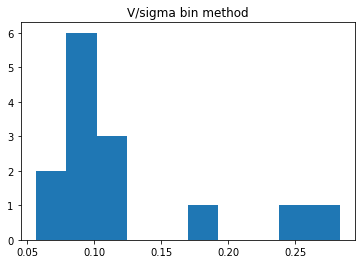

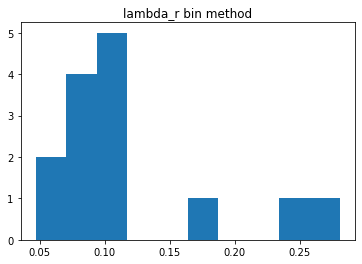

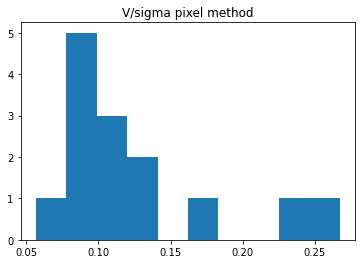

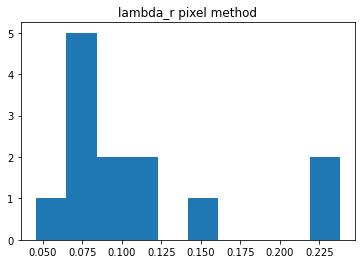

In [47]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

V_sigmas_bin_method = np.zeros(len(obj_names))
lambda_Rs_bin_method = np.zeros(len(obj_names))
V_ap_int_rms_bin_method = np.zeros(len(obj_names))
VD_ap_int_rms_bin_method = np.zeros(len(obj_names))
dV_ap_int_rms_bin_method = np.zeros(len(obj_names))
dVD_ap_int_rms_bin_method = np.zeros(len(obj_names))

V_sigmas_pixel_method = np.zeros(len(obj_names))
lambda_Rs_pixel_method = np.zeros(len(obj_names))
V_ap_int_rms_pixel_method = np.zeros(len(obj_names))
VD_ap_int_rms_pixel_method = np.zeros(len(obj_names))
dV_ap_int_rms_pixel_method = np.zeros(len(obj_names))
dVD_ap_int_rms_pixel_method = np.zeros(len(obj_names))


for i, obj_name in enumerate(obj_names):
       
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    print(f'length before cutting... {len(R)}')
    effective_radius = reffs[i]
    condition = R < effective_radius
    R_in_aperture = R[condition]
    V_in_aperture = V[condition]
    VD_in_aperture = VD[condition]
    dV_in_aperture = dV[condition]
    dVD_in_aperture = dVD[condition]
    bin_luminosities_in_aperture = bin_luminosities[condition]
    print(f'length after cutting... {len(R_in_aperture)}')
    #print()

    #################
    # calculate V_sigma
    V_sigmas_bin_method[i], \
        V_ap_int_rms_bin_method[i], \
        VD_ap_int_rms_bin_method[i], \
        dV_ap_int_rms_bin_method[i], \
        dVD_ap_int_rms_bin_method[i] = lum_weight_V_sigma ( V_in_aperture, 
                                                           VD_in_aperture, 
                                                           dV_in_aperture, 
                                                           dVD_in_aperture, 
                                                           bin_luminosities_in_aperture )
    # calculate lambda_R
    lambda_Rs_bin_method[i] = calc_lambda_R (V_in_aperture, VD_in_aperture, R_in_aperture, bin_luminosities_in_aperture)
    
    ###########################################
    # Now second method
    ###########################################
    
    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)
    
    # get effective radius
    #if obj_name == 'SDSSJ1306+0600':
    #    reff = 2.30
    #else:    
        # get reff from slacs table
    #    slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    #    slacs_table_name = obj_name[4:]
    #    slacs_reffs = slacs_table[:,7].astype(float)
    #    reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]
     
        
    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[j] = pixel_luminosity

    # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
    shells=[1.]
    luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                           num_bins, 
                                                           bin_luminosities, 
                                                           pixel_luminosities, 
                                                           shells, 
                                                           effective_radius)
    
    # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
    sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
    normalized_lum_weights = luminosity_weights / sum_lum_weights
    
    # calculate V_sigma# calculate lambda_R
    V_sigmas_pixel_method[i], lambda_Rs_pixel_method[i], \
        V_ap_int_rms_pixel_method[i], VD_ap_int_rms_pixel_method[i], \
        dV_ap_int_rms_pixel_method[i], dVD_ap_int_rms_pixel_method[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                                         V, VD, dV, dVD, 
                                                                                                                         pixel_luminosities, 
                                                                                                                         effective_radius)
    
    
plt.figure()    
plt.title('V/sigma bin method')
plt.hist(V_sigmas_bin_method)
plt.figure()
plt.title('lambda_r bin method')
plt.hist(lambda_Rs_bin_method)
    
plt.figure()    
plt.title('V/sigma pixel method')
plt.hist(V_sigmas_pixel_method)
plt.figure()
plt.title('lambda_r pixel method')
plt.hist(lambda_Rs_pixel_method)


In [48]:
VD_ap_int_rms_pixel_method

array([197.91364093, 257.50774565, 223.77450925, 256.49251394,
       244.3449066 , 221.5971728 , 226.01862958, 267.14904398,
       254.3862053 , 227.83327568, 241.72180773, 254.60489257,
       249.06311489, 244.37378391])

In [49]:
VD_ap_int_rms_bin_method

array([198.23527864, 257.86515898, 227.74603688, 255.24973187,
       245.83107397, 228.07360863, 225.98685823, 266.47704382,
       254.15471111, 228.92333289, 241.51338048, 254.50388677,
       248.27039202, 244.37378391])

In [50]:
classifications['VD_aperture']

0     197.913641
1     257.507746
2     223.774509
3     256.492514
4     244.344907
5     221.597173
6     226.018630
7     267.149044
8     254.386205
9     227.833276
10    241.721808
11    254.604893
12    249.063115
13    244.373784
Name: VD_aperture, dtype: float64

# Rename classifications columns

In [52]:
classifications.columns

Index(['Unnamed: 0', 'obj_name', 'class', 'subclass', 'comments',
       'ellipticity', 'V_sigma_mge', 'lambda_R_mge', 'PA_phot', 'delta_PA',
       'PA_kin', 'dPA_kin', 'oblate_prolate', 'SLACS delta_PA',
       'V_aperture_mge', 'VD_aperture_mge', 'dVD_aperture_mge',
       'Vrms_aperture_mge', 'SLACS VD', 'SLACS dVD', 'PA_kin_bspline',
       'dPA_kin_bspline', 'PA_phot_bspline', 'delta_PA_bspline',
       'ellipticity_bspline', 'kcwi_sigmapsf_bspline', 'reff_slacs_x',
       'ellipticity_slacs', 'reff_mge', 'reff_maj_mge', 'eps_reff_ellipse_mge',
       'luminosities_mge', 'reff_slacs_v', 'pa_slacs_v', 'VD_slacs_asb',
       'dVD_slacs_asb', 'V_sigma_bin', 'lambda_R_bin', 'D_ap_bin', 'dV_ap_bin',
       'VD_ap_bin', 'dVD_ap_bin', 'V_sigma_pix', 'lambda_R_pix', 'V_ap_pix',
       'dV_ap_pix', 'VD_ap_pix', 'dVD_ap_pix', 'V_aperture_mge.1',
       'VD_aperture_mge.1', 'Vrms_aperture_mge.1', 'V_sigma_class',
       'lambda_R_class', 'stellar_mass', 'V_aperture', 'VD_aperture',
       '

In [54]:
#classifications.rename(columns={'V_sigma':'V_sigma_mge',
#                               'lambda_R':'lambda_R_mge',
#                               'V_aperture':'V_aperture_mge',
#                               'VD_aperture':'VD_aperture_mge',
#                                'dV_aperture':'dV_aperture_mge',
#                                'dVD_aperture':'dVD_aperture_mge',
#                               'Vrms_aperture':'Vrms_aperture_mge'},
#                      inplace=True)

In [55]:
# update other columns

# add V_sigma and lambda_R, and ellipticities
classifications['ellipticity_slacs'] = slacs_v_ellipticities
classifications['reff_mge'] = reffs_mge
classifications['reff_maj_mge'] = reff_majs_mge
classifications['eps_reff_ellipse_mge'] = eps_reffs_mge
classifications['luminosities_mge'] = lums_mge
classifications['reff_slacs_v'] = slacs_v_reffs
classifications['pa_slacs_v'] = slacs_v_PA_phots
classifications['VD_slacs_asb'] = VD_slacs_asb
classifications['dVD_slacs_asb'] = dVD_slacs_asb
# bin and pixel methods
classifications['V_sigma_bin'] = V_sigmas_bin_method
classifications['lambda_R_bin'] = lambda_Rs_bin_method
classifications['D_ap_bin'] = V_ap_int_rms_bin_method
classifications['dV_ap_bin'] = dV_ap_int_rms_bin_method
classifications['VD_ap_bin'] = VD_ap_int_rms_bin_method
classifications['dVD_ap_bin'] = dVD_ap_int_rms_bin_method
classifications['V_sigma_pix'] = V_sigmas_pixel_method
classifications['lambda_R_pix'] = lambda_Rs_pixel_method
classifications['V_ap_pix'] = V_ap_int_rms_pixel_method
classifications['dV_ap_pix'] = dV_ap_int_rms_pixel_method
classifications['VD_ap_pix'] = VD_ap_int_rms_pixel_method
classifications['dVD_ap_pix'] = dVD_ap_int_rms_pixel_method

In [79]:
# for this purpose, take the ellipticity of J1306 to be the SLACS ellipticity. DO NOT SAVE.
#classifications.loc[6, 'ellipticity'] = classifications.loc[6, 'ellipticity_slacs']
classifications.loc[6, 'ellipticity_bspline'] = classifications.loc[6, 'ellipticity']
#lassifications.loc[6, 'class'] = 'fast/regular'

In [80]:
ellipticities = classifications.ellipticity_bspline
classes=classifications['class']

In [81]:
slow = classes == 'slow/nonregular'
fast = classes == 'fast/regular'
uncertain = classes == 'uncertain' # J0330
kdc = classes == 'fast/nonregular' #J1538

# separate into fast and slow
eps_slow = ellipticities[slow]
eps_fast = ellipticities[fast]

#################################################
#### pixel method
V_sigmas_pix_slow = V_sigmas_pixel_method[slow]
V_sigmas_pix_fast = V_sigmas_pixel_method[fast]

lambda_Rs_pix_slow = lambda_Rs_pixel_method[slow]
lambda_Rs_pix_fast = lambda_Rs_pixel_method[fast]

# uncertain
eps_uncertain = ellipticities[uncertain]
V_sigmas_pix_uncertain = V_sigmas_pixel_method[uncertain]
lambda_Rs_pix_uncertain = lambda_Rs_pixel_method[uncertain]

# fast nonregular
eps_fast_kdc = ellipticities[kdc]
V_sigmas_pix_fast_kdc = V_sigmas_pixel_method[kdc]
lambda_Rs_pix_fast_kdc = lambda_Rs_pixel_method[kdc]

#################################################
#### bin method
V_sigmas_bin_slow = V_sigmas_bin_method[slow]
V_sigmas_bin_fast = V_sigmas_bin_method[fast]

lambda_Rs_bin_slow = lambda_Rs_bin_method[slow]
lambda_Rs_bin_fast = lambda_Rs_bin_method[fast]

# uncertain
eps_uncertain = ellipticities[uncertain]
V_sigmas_bin_uncertain = V_sigmas_bin_method[uncertain]
lambda_Rs_bin_uncertain = lambda_Rs_bin_method[uncertain]

# fast nonregular
eps_fast_kdc = ellipticities[kdc]
V_sigmas_bin_fast_kdc = V_sigmas_bin_method[kdc]
lambda_Rs_bin_fast_kdc = lambda_Rs_bin_method[kdc]

In [82]:
# make elliptical marker
import matplotlib.path as mpath

# Define the ellipse marker.
circle = mpath.Path.unit_circle()
elliptical_verts = np.copy(circle.vertices)
elliptical_verts[:, 0] *= 1.618
elliptical_marker = mpath.Path(elliptical_verts, circle.codes)

# define negative smaller ellipse
inner_ell_verts = elliptical_verts * 0.8

# make ellipse with line marker
rect = mpath.Path.unit_rectangle()
rect_verts = np.copy(rect.vertices)
rect_verts[:,0] *= 0.1
rect_verts[:,1] *= 2.0
line_marker = mpath.Path(rect_verts, rect.codes)

# make another line marker lower
second_line_verts = rect_verts.copy()
second_line_verts[:,1] += -3.5
second_line_verts[:,1] *= 0.5

rotator = mpath.Path(
    vertices=np.concatenate([elliptical_verts, inner_ell_verts[::-1, ...], rect_verts, second_line_verts]),
    codes=np.concatenate([circle.codes, circle.codes, rect.codes, rect.codes]))

nonregular = 'o'

# make a question mark
uncertain_mark = '$?$'

# fast/non (kdc)
kdc_mark = '^'


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


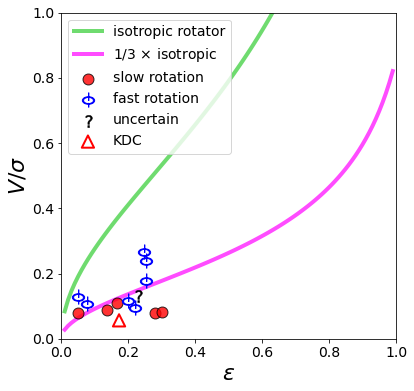

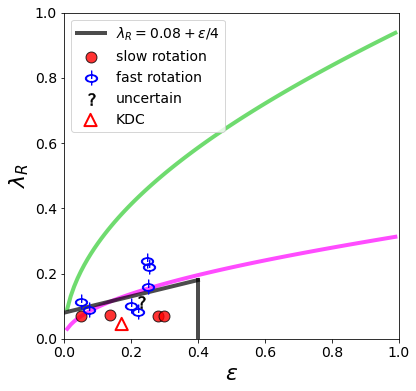

In [83]:
# plot the V_sigma and lambda_R to ellipticities

plt.rcParams.update({'font.size': 14})

epsilons = np.linspace(0.0,1.0,100)
V_sigmas_iso = np.zeros(100)
lambda_Rs_iso = np.zeros(100)

i=0
for epsilon in epsilons:
    V_sigma = calc_isotropic_V_sigma(epsilon)
    V_sigmas_iso[i] = V_sigma
    lambda_Rs_iso[i] = calc_Vsig_to_lamR(V_sigma)
    i = i+1

# plot the V_sigma and lambda_R to ellipticities

###################################
# V sigma

plt.figure(figsize=(6,6))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)

# curves
plt.plot(epsilons, V_sigmas_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7,
        label='isotropic rotator')
plt.plot(epsilons, 1/3 * V_sigmas_iso, 
         c='magenta',linewidth=4,zorder=-1, alpha=0.7,
        label=r'1/3 $\times$ isotropic')

# scatter plot for the datapoints
plt.scatter(eps_slow, V_sigmas_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotation', alpha=0.8)
plt.scatter(eps_fast, V_sigmas_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotation')
plt.scatter(eps_uncertain, V_sigmas_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(eps_fast_kdc, V_sigmas_pix_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

plt.xlabel(r'$\epsilon$',fontsize=22)
plt.ylabel(r'$V/\sigma$',fontsize=22)
plt.legend(fontsize=14)
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_vsigma_pix.pdf')

###################################
# Lambda_R

plt.figure(figsize=(6,6))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)

# curves
plt.plot(epsilons, lambda_Rs_iso, 
         c='limegreen',linewidth=4,zorder=-1, alpha=0.7)
plt.plot(epsilons, 1/3 * lambda_Rs_iso, 
         c='magenta',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.0, 0.4],[0.08, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7)
plt.plot([0.4, 0.4],[0.0, 0.08+0.4/4],
         linestyle='-',c='k',linewidth=4,zorder=-1, alpha=0.7,
        label=r'$\lambda_R = 0.08 + \epsilon/4$')

# scatter plots for the datapoints
plt.scatter(eps_slow, lambda_Rs_pix_slow, 
            s=120, c='r', marker=nonregular, edgecolor='k', linewidth=1,
            label='slow rotation', alpha=0.8)
plt.scatter(eps_fast, lambda_Rs_pix_fast, 
            s=230, c='b', marker=rotator, 
            label='fast rotation')
plt.scatter(eps_uncertain, lambda_Rs_pix_uncertain, 
            s=150, c='k', marker=uncertain_mark, linewidth=0.5, 
            label='uncertain')
plt.scatter(eps_fast_kdc, lambda_Rs_pix_fast_kdc, 
            s=150, marker='^', edgecolor='red', facecolor='none', linewidth=2, 
            label='KDC')

plt.xlabel(r'$\epsilon$',fontsize=22)
plt.ylabel(r'$\lambda_R$',fontsize=22)
plt.legend(fontsize=14, loc='upper left')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix.png')
plt.savefig(f'{data_dir}mosaics/kinematic_class_lambdar_pix.pdf')

In [97]:
V_aperture = V_ap_int_rms_pixel_method
VD_aperture = VD_ap_int_rms_pixel_method
dV_aperture = V_ap_int_rms_pixel_method
dVD_aperture = dVD_ap_int_rms_pixel_method
Vrms_aperture = np.sqrt((V_aperture**2 + VD_aperture**2)/2)

In [85]:
# classification according to the Cappellari paper

V_sigmas = classifications['V_sigma_pix']
lambda_Rs = classifications['lambda_R_pix']

V_sig_class = np.empty(14, dtype='U5')
lam_R_class = np.empty(14, dtype='U5')

for i in range(14):
    
    #print(obj_names[i])
    
    V_sig = V_sigmas[i]
    lam_R = lambda_Rs[i]
    ellip = ellipticities[i]
    
    V_sig_bound = calc_isotropic_V_sigma(ellip) / 3
    lam_R_bound = 0.08 + ellip/4
    
    if (V_sig < V_sig_bound):
        V_sig_class[i] = 'slow'
    elif (V_sig > V_sig_bound):
        V_sig_class[i] = 'fast'
    
    if (lam_R < lam_R_bound):
        lam_R_class[i] = 'slow'
    elif (lam_R > lam_R_bound):
        lam_R_class[i] = 'fast'
    
classifications['V_sigma_class'] = V_sig_class
classifications['lambda_R_class'] = lam_R_class

# Look at stellar masses from https://arxiv.org/pdf/1407.5633.pdf
## Take Mag_r, M/L_r from tables 1 and 2
## See how they split across M_* = 2e11 M_sun

In [86]:
# take the sdss r mag
r_mags = np.array([-22.79,
                  -23.20,
                  -22.93,
                  -23.02,
                   -22.16,
                   -23.11,
                   0.0,
                   -23.14,
                   -23.04,
                   -21.98,
                   -23.22,
                   -22.78,
                   -23.18,
                   -22.83
                  ])

# solar magnitude in sdss r
mag_sun_r = 4.64 # (Blanton & Roweis 2007)

# convert to luminosity
lum_rs = 10**(0.4*(mag_sun_r - r_mags)) # solar luminosities

# take the ml_MFL, logs
log_ml_rs = np.array([0.693,
                     0.665,
                     0.487,
                     0.793,
                     0.835,
                     0.548, 
                      -1.0,
                      0.706, 
                     0.728,
                     0.577,
                     0.571,
                     0.830,
                     0.671,
                     0.779])

# convert from log
ml_rs = 10**log_ml_rs

# multiply mass to light by the light to get mass
stellar_masses = ml_rs * lum_rs

stellar_masses

array([4.62381021e+11, 6.32411851e+11, 3.27340695e+11, 7.19448978e+11,
       3.58921935e+11, 4.44631267e+11, 7.17794291e+00, 6.57657837e+11,
       6.30957344e+11, 1.67880402e+11, 5.18800039e+11, 6.28058359e+11,
       6.29506183e+11, 5.84790084e+11])

In [87]:
# from https://ui.adsabs.harvard.edu/abs/2009ApJ...705.1099A/abstract
# stellar masses are in log
log_stellar_masses_salp = np.array([11.58,
                                   11.73,
                                   11.58,
                                   11.76,
                                   11.45,
                                   11.77,
                                   11.43,
                                   11.79,
                                   11.68,
                                   11.28,
                                   11.70,
                                   11.70,
                                   11.86,
                                   11.71]) 

dlog_stellar_masses_salp = np.array([0.13,
                                    0.06,
                                    0.09,
                                    0.08,
                                    0.06,
                                    0.07,
                                    0.08,
                                    0.06,
                                    0.09,
                                    0.08,
                                    0.07,
                                    0.09,
                                    0.07,
                                    0.06])

# take from log
stellar_masses_salp = 10**log_stellar_masses_salp

# convert to scientific notation
for i in range(len(stellar_masses_salp)):
    sci = np.format_float_scientific(stellar_masses_salp[i])
    stellar_masses_salp[i] = sci

stellar_masses_salp

array([3.80189396e+11, 5.37031796e+11, 3.80189396e+11, 5.75439937e+11,
       2.81838293e+11, 5.88843655e+11, 2.69153480e+11, 6.16595002e+11,
       4.78630092e+11, 1.90546072e+11, 5.01187234e+11, 5.01187234e+11,
       7.24435960e+11, 5.12861384e+11])

In [88]:
# add the stellar masses
classifications['stellar_mass'] = stellar_masses
# for i=6 use salp
classifications.loc[6, 'stellar_mass'] = stellar_masses_salp[6]

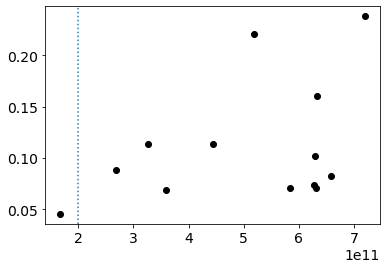

In [89]:
# plot against lambda_R
colors=['k','b','g','r']
plt.scatter(classifications['stellar_mass'], lambda_Rs, color='k')
plt.axvline(2e11, linestyle=':')

In [90]:
# save the classifications to a new table
#date = '022123'
#classifications.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)

# Look at aperture effects by integrating velocities at a range of aperture radii.
# 1/4 reff, 1/2 reff, 3/4 reff, 1 reff, 1.25, 1.5 etc


In [91]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

reff_factors = np.array([0.25,
                     0.5,
                     0.75,
                     1.0,
                     1.25,
                     1.5])

V_sigmas_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
lambda_Rs_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
V_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
VD_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dV_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dVD_ap_int_rms_bin_method_aptest = np.zeros((len(reff_factors), len(obj_names)))

V_sigmas_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
lambda_Rs_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
V_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
VD_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dV_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))
dVD_ap_int_rms_pixel_method_aptest = np.zeros((len(reff_factors), len(obj_names)))


for i, obj_name in enumerate(obj_names):
    
    print('Object ' + obj_name)
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    print(f'length before cutting... {len(R)}')
    effective_radius = reffs[i]
    for k, factor in enumerate(reff_factors):
        print('factor ', factor)
        condition = R < factor*effective_radius
        R_in_aperture = R[condition]
        V_in_aperture = V[condition]
        VD_in_aperture = VD[condition]
        dV_in_aperture = dV[condition]
        dVD_in_aperture = dVD[condition]
        bin_luminosities_in_aperture = bin_luminosities[condition]
        print(f'length after cutting... {len(R_in_aperture)}')
        #print()

        #################
        # calculate V_sigma
        V_sigmas_bin_method_aptest[k,i], V_ap_int_rms_bin_method_aptest[k,i], \
            VD_ap_int_rms_bin_method_aptest[k,i], dV_ap_int_rms_bin_method_aptest[k,i], \
                dVD_ap_int_rms_bin_method_aptest[k,i] = lum_weight_V_sigma ( V_in_aperture, VD_in_aperture, 
                                                                            dV_in_aperture, dVD_in_aperture, 
                                                                            bin_luminosities_in_aperture )
        # calculate lambda_R
        lambda_Rs_bin_method_aptest[k,i] = calc_lambda_R (V_in_aperture, VD_in_aperture, R_in_aperture, bin_luminosities_in_aperture)

        ###########################################
        # Now second method
        ###########################################

        # bring in cropped datacube and sum across wavelengths
        file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
        datacube = fits.open(file)[0].data
        summed_datacube = np.nansum(datacube, axis=0)
        normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

        # get effective radius
        #if obj_name == 'SDSSJ1306+0600':
        #    reff = 2.30
        #else:    
            # get reff from slacs table
        #    slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
        #    slacs_table_name = obj_name[4:]
        #    slacs_reffs = slacs_table[:,7].astype(float)
        #    reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]


        # calculate pixel luminosities
        pixel_luminosities = np.zeros(len(vorbin_pixels))
        for j in range(len(vorbin_pixels)):
            x = int(vorbin_pixels[j,0])
            y = int(vorbin_pixels[j,1])
            pixel_luminosity = summed_datacube[y,x]
            pixel_luminosities[j] = pixel_luminosity

        # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
        shells=[1.]
        luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                               num_bins, 
                                                               bin_luminosities, 
                                                               pixel_luminosities, 
                                                               shells, 
                                                               factor*effective_radius)

        # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
        sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
        normalized_lum_weights = luminosity_weights / sum_lum_weights

        # calculate V_sigma# calculate lambda_R
        V_sigmas_pixel_method_aptest[k,i], \
            lambda_Rs_pixel_method_aptest[k,i], \
            V_ap_int_rms_pixel_method_aptest[k,i], \
            VD_ap_int_rms_pixel_method_aptest[k,i], \
            dV_ap_int_rms_pixel_method_aptest[k,i], \
            dVD_ap_int_rms_pixel_method_aptest[k,i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                         V, VD, dV, dVD, 
                                                                                                         pixel_luminosities, 
                                                                                                         factor*effective_radius)

    



Object SDSSJ0029-0055
length before cutting... 193
factor  0.25
length after cutting... 45
factor  0.5
length after cutting... 137
factor  0.75
length after cutting... 174
factor  1.0
length after cutting... 190
factor  1.25
length after cutting... 193


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in true_divide


factor  1.5
length after cutting... 193
Object SDSSJ0037-0942
length before cutting... 303
factor  0.25
length after cutting... 45
factor  0.5
length after cutting... 177
factor  0.75
length after cutting... 252
factor  1.0
length after cutting... 286
factor  1.25
length after cutting... 303
factor  1.5
length after cutting... 303
Object SDSSJ0330-0020
length before cutting... 12
factor  0.25
length after cutting... 1
factor  0.5
length after cutting... 3
factor  0.75
length after cutting... 5
factor  1.0
length after cutting... 7
factor  1.25
length after cutting... 12
factor  1.5
length after cutting... 12
Object SDSSJ1112+0826
length before cutting... 18
factor  0.25
length after cutting... 2
factor  0.5
length after cutting... 10
factor  0.75
length after cutting... 12
factor  1.0
length after cutting... 18
factor  1.25
length after cutting... 18
factor  1.5
length after cutting... 18
Object SDSSJ1204+0358
length before cutting... 99
factor  0.25
length after cutting... 21
factor  

ValueError: x and y must have same first dimension, but have shapes (15,) and (6,)

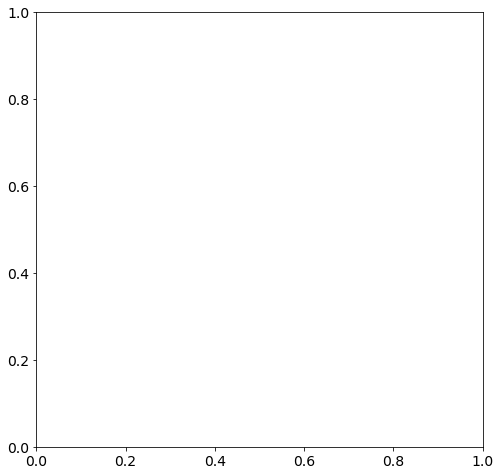

In [171]:
# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/reffs

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    #if i==6:
    #    continue
    ax.plot(reff_factors, 
                VD_ap_int_rms_pixel_method_aptest[:,i], 
                #yerr=dVD_ap_int_rms_pixel_method_aptest[:,i], 
                color=cmap(i),
               marker='',
            markersize=10,
            linestyle='--',
           linewidth=2,
           zorder=-1)
    #axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest[:,i], c='k')
    
    ax.errorbar(aperture_ratios[i], 
                #sdss_sigmas[i], 
                #yerr=sdss_sigmas_err[i], 
                VD_slacs_asb[i],
                dVD_slacs_asb[i],
                color=cmap(i),
               marker='s',
              markersize=10,
              markeredgecolor='k',
               elinewidth=2,
                ecolor='k',
                label=obj_names[i]
               )
ax.axvline(1.00, 0, 1, c='k', linestyle=':')
ax.set_xticks(reff_factors)
ax.set_ylim(170, 300)
ax.set_xlim(0.25, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap} [km/s]$')
ax.legend(bbox_to_anchor=(1.0,1.0))

plt.savefig(f'{figure_dir}aperture_integration_effects_{date}.pdf', bbox_inches='tight')

# I need the "not_na" index, which just removes object 6.

In [94]:
not_na = np.isfinite(np.log10(reffs_mge))

In [95]:
not_na

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

# Some people think there is a $\sigma/\sigma_e = (r/r_e)^{-0.09}$ relation.

Text(0.5, 1.0, 'SDSS/SLACS measurements versus KCWI aperture and $R_{eff}$')

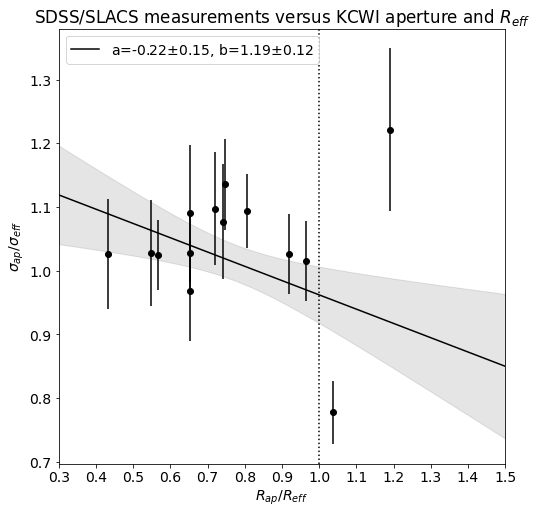

In [144]:
# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there


cmap = get_cmap(14)

#aperture_ratios = 1.5/slacs_reffs # This isn't right because I have defined my VD_aperture (at reff) to be at the MGE reff.
#sigma_ratios = sdss_sigmas/VD_aperture
aperture_ratios = 1.5/reffs
sigma_ratios = VD_slacs_asb/VD_aperture
dsigma_ratios = sigma_ratios * np.sqrt((dVD_slacs_asb/VD_slacs_asb)**2 + (dVD_aperture/VD_aperture)**2)

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    #if i==6:
    #    continue
    ax.errorbar(aperture_ratios[i], sigma_ratios[i], yerr=dsigma_ratios[i], color='k', marker='o')#, s=60)
ax.axvline(1.00, 0, 1, c='k', linestyle=':')

# linear fit
p, cov = np.polyfit(aperture_ratios[not_na], sigma_ratios[not_na], w=1/dsigma_ratios[not_na], deg=1, cov=True)
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))
merr = err[0]
berr = err[1]
x = np.linspace(0.3, 1.5, 100)
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='k', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

ax.legend()
ax.set_xticks(reff_factors)
#ax.set_ylim(180, 330)
ax.set_xlim(0.3, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
ax.set_title(r'SDSS/SLACS measurements versus KCWI aperture and $R_{eff}$')

#plt.savefig(f'{figure_dir}sigma_ratio_radius_ratio_integration_effects_slacs_measurements_{date}.pdf')

################


In [145]:
reffs

0     2.297969
1     2.300096
2     1.258860
3     1.554640
4     1.630916
5     1.860277
6     2.081975
7     2.651677
8     2.733963
9     1.445092
10    2.297421
11    2.019336
12    2.006697
13    3.461659
Name: reff_kpc, dtype: float64

In [105]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

aperture_size = 1.5 # arcsec

V_sigmas_bin_method_sdssap = np.zeros((len(obj_names)))
lambda_Rs_bin_method_sdssap = np.zeros((len(obj_names)))
V_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))
VD_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))
dV_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))
dVD_ap_int_rms_bin_method_sdssap = np.zeros((len(obj_names)))

V_sigmas_pixel_method_sdssap = np.zeros((len(obj_names)))
lambda_Rs_pixel_method_sdssap = np.zeros((len(obj_names)))
V_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))
VD_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))
dV_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))
dVD_ap_int_rms_pixel_method_sdssap = np.zeros((len(obj_names)))


for i, obj_name in enumerate(obj_names):
    
    print('Object ' + obj_name)
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        

    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    print(f'length before cutting... {len(R)}')
    effective_radius = reffs[i]
    condition = R < aperture_size# factor*effective_radius
    R_in_aperture = R[condition]
    V_in_aperture = V[condition]
    VD_in_aperture = VD[condition]
    dV_in_aperture = dV[condition]
    dVD_in_aperture = dVD[condition]
    bin_luminosities_in_aperture = bin_luminosities[condition]
    print(f'length after cutting... {len(R_in_aperture)}')
    #print()

    #################
    # calculate V_sigma
    V_sigmas_bin_method_sdssap[i], V_ap_int_rms_bin_method_sdssap[i], \
        VD_ap_int_rms_bin_method_sdssap[i], dV_ap_int_rms_bin_method_sdssap[i], \
            dVD_ap_int_rms_bin_method_sdssap[i] = lum_weight_V_sigma ( V_in_aperture, VD_in_aperture, 
                                                                        dV_in_aperture, dVD_in_aperture, 
                                                                        bin_luminosities_in_aperture )
    # calculate lambda_R
    lambda_Rs_bin_method_sdssap[i] = calc_lambda_R (V_in_aperture, VD_in_aperture, R_in_aperture, bin_luminosities_in_aperture)

    ###########################################
    # Now second method
    ###########################################

    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

    # get effective radius
    #if obj_name == 'SDSSJ1306+0600':
    #    reff = 2.30
    #else:    
        # get reff from slacs table
    #    slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    #    slacs_table_name = obj_name[4:]
    #    slacs_reffs = slacs_table[:,7].astype(float)
    #    reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]


    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[j] = pixel_luminosity

    # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
    shells=[1.]
    luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                           num_bins, 
                                                           bin_luminosities, 
                                                           pixel_luminosities, 
                                                           shells, 
                                                           aperture_size)

    # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
    sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
    normalized_lum_weights = luminosity_weights / sum_lum_weights

    # calculate V_sigma# calculate lambda_R
    V_sigmas_pixel_method_sdssap[i], \
        lambda_Rs_pixel_method_sdssap[i], \
        V_ap_int_rms_pixel_method_sdssap[i], \
        VD_ap_int_rms_pixel_method_sdssap[i], \
        dV_ap_int_rms_pixel_method_sdssap[i], \
        dVD_ap_int_rms_pixel_method_sdssap[i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                     V, VD, dV, dVD, 
                                                                                                     pixel_luminosities, 
                                                                                                     aperture_size)





Object SDSSJ0029-0055
length before cutting... 193
length after cutting... 162
Object SDSSJ0037-0942
length before cutting... 303
length after cutting... 228
Object SDSSJ0330-0020
length before cutting... 12
length after cutting... 11
Object SDSSJ1112+0826
length before cutting... 18
length after cutting... 18
Object SDSSJ1204+0358
length before cutting... 99
length after cutting... 85
Object SDSSJ1250+0523
length before cutting... 65
length after cutting... 53
Object SDSSJ1306+0600
length before cutting... 64
length after cutting... 51
Object SDSSJ1402+6321
length before cutting... 108
length after cutting... 91
Object SDSSJ1531-0105
length before cutting... 39
length after cutting... 28
Object SDSSJ1538+5817
length before cutting... 45
length after cutting... 34
Object SDSSJ1621+3931
length before cutting... 37
length after cutting... 30
Object SDSSJ1627-0053
length before cutting... 71
length after cutting... 58
Object SDSSJ1630+4520
length before cutting... 52
length after cutting.

In [106]:
# also show the 1/2 Reff measurement
VD_half_reff = VD_ap_int_rms_pixel_method_aptest[1,:]
dVD_half_reff = dVD_ap_int_rms_pixel_method_aptest[1,:]
VD_half_reff

array([206.07884759, 271.21125008, 230.13290786, 268.95840475,
       257.9439071 , 234.51750861, 234.1454215 , 278.24972386,
       265.49211941, 236.40428264, 255.87823383, 259.21169986,
       267.54036937, 247.04008271])

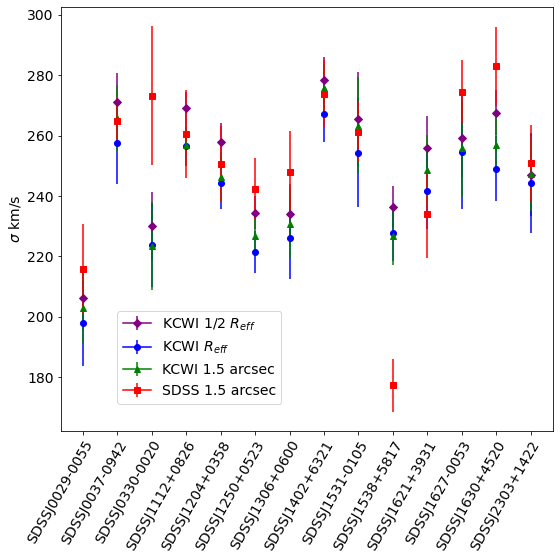

In [111]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,8))
for i in range(14):
    plt.errorbar(i, VD_half_reff[i], yerr=dVD_half_reff[i], c='purple', marker='D')
    plt.errorbar(i, VD_aperture[i], yerr=dVD_aperture[i], c='b', marker='o')
    plt.errorbar(i, VD_ap_int_rms_pixel_method_sdssap[i], yerr=dVD_ap_int_rms_pixel_method_sdssap[i], c='g', marker='^')
    plt.errorbar(i, VD_slacs_asb[i], yerr=dVD_slacs_asb[i], c='r', marker='s')
#    plt.errorbar(i, sdss_sigmas[i], yerr=sdss_sigmas_err[i], c='r', marker='x', alpha=0.1)
    #plt.errorbar(i, VD_slacs_asb[i], yerr=dVD_slacs_asb[i], c='r', marker='s')
    if i==0:
        plt.legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   bbox_to_anchor=(0.1,0.3))
plt.xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
plt.ylabel(r'$\sigma$ km/s')
plt.tight_layout()
#plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_{date}.pdf', bbox_inches='tight')

# Look at the velocity dispersions

In [112]:
np.mean((VD_ap_int_rms_pixel_method_sdssap[not_na]-VD_slacs_asb[not_na])/VD_slacs_asb[not_na])

-0.015550768651421512

# The KCWI and SDSS versions at 1.5 arcsec agree to 1.6%

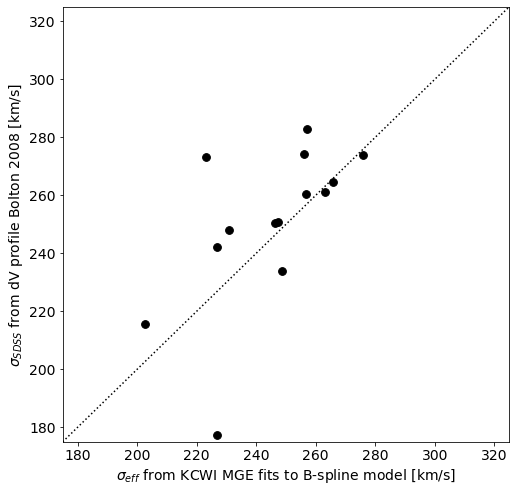

In [114]:
x = np.linspace(175,325, 100)
y = x

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(VD_ap_int_rms_pixel_method_sdssap[not_na], VD_slacs_asb[not_na], c='k', s=60)
ax.set_xlim(175,325)
ax.set_ylim(175,325)
ax.set_ylabel(r'$\sigma_{SDSS}$ from dV profile Bolton 2008 [km/s]')
ax.set_xlabel(r'$\sigma_{eff}$ from KCWI MGE fits to B-spline model [km/s]')
ax.plot(x, y, 'k:')


-0.049410047148433875 1.0553800736109187
[0.01340495 0.0105309 ]


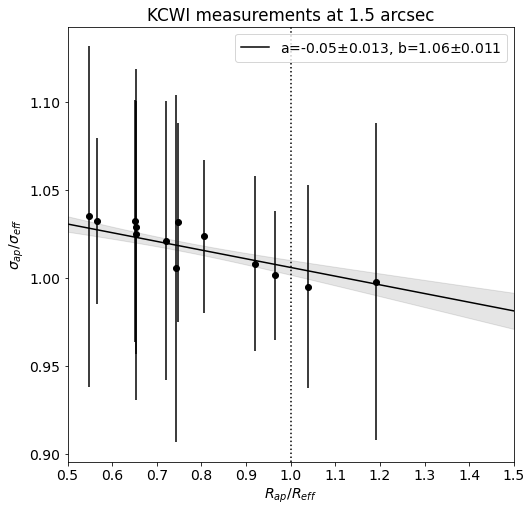

In [146]:

# calculate the SDSS aperture radius divided by the effective radius, plot SDSS sigma there
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(14)

aperture_ratios = 1.5/reffs
sigma_ratios = VD_ap_int_rms_pixel_method_sdssap/VD_aperture
dsigma_ratios = sigma_ratios * np.sqrt((dVD_ap_int_rms_pixel_method_sdssap/VD_ap_int_rms_pixel_method_sdssap)**2 + (dVD_aperture/VD_aperture)**2)

# plot
fig, ax = plt.subplots(1, figsize=(8,8))
for i in range(len(obj_names)):
    #if i==6:
    #    continue
    ax.errorbar(aperture_ratios[i], sigma_ratios[i], dsigma_ratios[i], color='k', marker='o')#, s=60)
ax.axvline(1.00, 0, 1, c='k', linestyle=':')

# linear fit
n_obj = len(aperture_ratios[not_na]) # number objects fit
p, cov = np.polyfit(aperture_ratios[not_na], sigma_ratios[not_na], deg=1, cov=True)
m=p[0]
b=p[1]
err =np.sqrt(np.diag(cov))#/np.sqrt(n_obj)
merr = err[0]
berr = err[1]
print(m, b)
print(err)

# plot the linear relation
x=np.linspace(0.5,1.5)
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.3f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.3f}".format(berr)}'
plt.plot(x, nom, c='k', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

ax.legend()
ax.set_xticks(reff_factors)
#ax.set_ylim(180, 330)
ax.set_xlim(0.5, 1.5)
ax.set_xlabel(r'$R_{ap}/R_{eff}$')
ax.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
ax.set_title('KCWI measurements at 1.5 arcsec')
ax.legend()

plt.savefig(f'{figure_dir}sigma_ratio_radius_ratio_integration_effects_kcwi_measurements_{date}.pdf')

In [118]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

reff_factors = np.arange(0.1, 1.6, 0.1)#np.array([0.25,
               #      0.5,
               #      0.75,
               #      1.0,
               #      1.25,
               #      1.5])


V_sigmas_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
lambda_Rs_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
V_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
VD_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
dV_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))
dVD_ap_int_rms_pixel_method_aptest2 = np.zeros((len(reff_factors), len(obj_names)))


for i, obj_name in enumerate(obj_names):
    
    print('Object ' + obj_name)
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        
       
    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)


    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[j] = pixel_luminosity
        
    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    #print(f'length before cutting... {len(R)}')
    effective_radius = reffs[i]

    # loop through the different apertures    
    for k, factor in enumerate(reff_factors):
        # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
        shells=[1.]
        luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                               num_bins, 
                                                               bin_luminosities, 
                                                               pixel_luminosities, 
                                                               shells, 
                                                               factor*effective_radius)

        # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
        sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
        normalized_lum_weights = luminosity_weights / sum_lum_weights

        # calculate V_sigma# calculate lambda_R
        V_sigmas_pixel_method_aptest2[k,i], \
            lambda_Rs_pixel_method_aptest2[k,i], \
            V_ap_int_rms_pixel_method_aptest2[k,i], \
            VD_ap_int_rms_pixel_method_aptest2[k,i], \
            dV_ap_int_rms_pixel_method_aptest2[k,i], \
            dVD_ap_int_rms_pixel_method_aptest2[k,i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                         V, VD, dV, dVD, 
                                                                                                         pixel_luminosities, 
                                                                                                         factor*effective_radius)

    



Object SDSSJ0029-0055


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in sqrt
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


Object SDSSJ0037-0942
Object SDSSJ0330-0020
Object SDSSJ1112+0826


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: RuntimeWarning: invalid value encountered in double_scalars


Object SDSSJ1204+0358
Object SDSSJ1250+0523
Object SDSSJ1306+0600
Object SDSSJ1402+6321
Object SDSSJ1531-0105
Object SDSSJ1538+5817
Object SDSSJ1621+3931
Object SDSSJ1627-0053
Object SDSSJ1630+4520
Object SDSSJ2303+1422


In [119]:
# take the ratio of each velocity dispersion to the one at the effective radius
VD_ratio = VD_ap_int_rms_pixel_method_aptest2 / VD_ap_int_rms_pixel_method_aptest2[9]
dVD_ratio = VD_ratio * np.sqrt((dVD_ap_int_rms_pixel_method_aptest2/VD_ap_int_rms_pixel_method_aptest2)**2 \
                               + (dVD_ap_int_rms_pixel_method_aptest2[9]/VD_ap_int_rms_pixel_method_aptest2[9])**2)
# take the effective radius factors as the x axis

mean p0, mean p1,  -0.04105176475517345 0.0018896879009913348
merr, berr 0.01394120598116275 0.004640393631915629


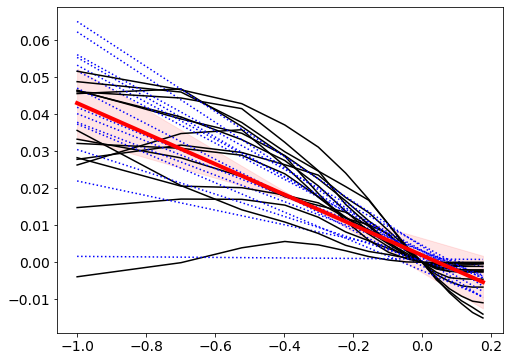

In [147]:
# plot

logx = np.log10(reff_factors)
logy = np.log10(VD_ratio[:,not_na])
dlogy = dVD_ratio[:,not_na]/VD_ratio[:,not_na]

p0s = np.zeros(14)
p1s = np.zeros(14)
variances = np.zeros((14, 2))

fig, axs = plt.subplots(figsize=(8,6))
for i in range(14):
    p, cov = np.polyfit(logx, logy[:,i], w=dlogy[:,i], deg=1, cov=True)
    p0s[i] = p[0]
    p1s[i] = p[1]
    variances[i] = np.diag(cov)
    fit = p[0]*logx + p[1]
    axs.plot(logx, logy[:,i], c='k')
    axs.plot(logx, fit, c='b', linestyle=':')
   # axs[1].plot(reff_factors, VD_ap_int_rms_bin_method_aptest2[:,i], c='k')

m = np.mean(p0s)
b = np.mean(p1s)
merr = np.sqrt(np.sum(variances[:,0]))
berr = np.sqrt(np.sum(variances[:,1]))

yfit = m*logx+b
yfit_err_low = (m-merr)*logx+(b-berr)
yfit_err_hi = (m+merr)*logx+(b+berr)

print('mean p0, mean p1, ', m, b)
print('merr, berr', merr, berr)
plt.plot(logx, yfit, 'r', linewidth=4)
plt.fill_between(logx, yfit_err_low, yfit_err_hi, color='r', alpha=0.1)



# A linear regression fit to log-log space is not exactly the same thing as fitting the power law directly because the log-log linear fit is minimizing the difference log(y_data) - log(y_model) = log(y_data/y_model), which means it's really minimizing the *ratio* or relative difference. This isn't necessarily wrong, but it is not the same.

In [121]:
# import curve fit and define the power law to be fit
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return b*np.power(x, a)

x = np.linspace(0,10,100)
y = power_law(x, 2, 4)


pl weighted fit: mean -0.04234765395888164


(0.975, 1.125)

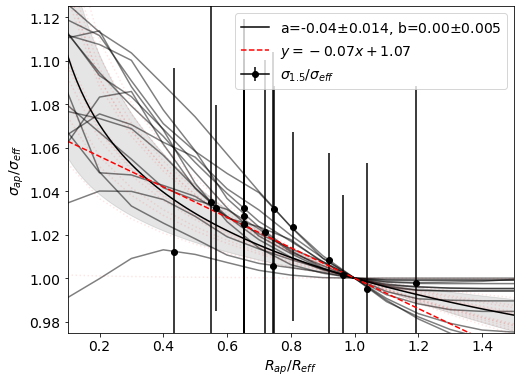

In [148]:
def power_law_fixed(x, a):
    return np.power(x, a)

# weighted
ps = np.zeros(14)
variances = np.zeros((14, 2))

aperture_ratios = 1.5/np.array(reffs)
sigma_ratios = VD_ap_int_rms_pixel_method_sdssap/VD_aperture
dsigma_ratios = sigma_ratios * np.sqrt((dVD_ap_int_rms_pixel_method_sdssap/VD_ap_int_rms_pixel_method_sdssap)**2 + (dVD_aperture/VD_aperture)**2)


fig, axs = plt.subplots(figsize=(8,6))#, gridspec_kw={'height_ratios': [4, 1]})
plt.subplots_adjust(hspace=0.25)
for i in range(14):
    # plot the data
    axs.plot(reff_factors, VD_ratio[:,not_na][:,i], c='k', alpha=0.5)
    # weighted
    p, cov = curve_fit(f=power_law_fixed, xdata=reff_factors, ydata=VD_ratio[:,not_na][:,i], p0=[0], 
                       sigma=dVD_ratio[:,not_na][:,i], 
                       absolute_sigma=True,
                       bounds=(-np.inf, np.inf))
    ps[i] = p
    variances[i] = cov
    fit = power_law_fixed(reff_factors, p)
    axs.plot(reff_factors, fit, c='r', linestyle=':', alpha=0.1)
    # plot the ratios of kcwi - 1.5 to reff
    if i==0:
            axs.errorbar(aperture_ratios[not_na][i], sigma_ratios[not_na][i], yerr=dsigma_ratios[not_na][i],
                        marker='o', c='k', label=r'$\sigma_{1.5}/\sigma_{eff}$')
    axs.errorbar(aperture_ratios[not_na][i], sigma_ratios[not_na][i], yerr=dsigma_ratios[not_na][i],
                marker='o', c='k')#, s=60)

# take the weighted mean of parameters for each fit # (weighted by inverse variance)
# weighted
mean = np.average(ps)#, weights=1/variances_w[:,0])
mean_var = np.average(variances)
mean_err = np.sqrt(mean_var/14)

print('pl weighted fit: mean', mean)

# plot the fit curve relation
x=np.linspace(0.1, 1.5, 100)
ac = unc.correlated_values(np.array([mean]), np.array([[mean_var]])) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = power_law_fixed(x, ac)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.3f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.3f}".format(berr)}'
plt.plot(x, nom, c='k', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

#mean_wfit = power_law_fixed(reff_factors, mean)
#mean_wfit_low = power_law_fixed(reff_factors, mean-mean_err)
#mean_wfit_hi = power_law_fixed(reff_factors, mean+mean_err)

#axs.plot(reff_factors, mean_wfit, c='b', linewidth=3, label=f'power law {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(np.sqrt(mean_var))}')
#axs.fill_between(reff_factors, mean_wfit_low, mean_wfit_hi, color='b', alpha=0.2)
#axs[0].plot(reff_factors, mean_mean_fit_low, linewidth=10)
#axs[1].axhline(mean_var0, 0, 1, c='b')         
# plot the linear correlation for aperture of 1.5 arcseconds
axs.plot(reff_factors, -0.07*reff_factors+1.07, 
        color='r',
        linestyle='--',
        label=r'$y = -0.07 x + 1.07$',
        )
    
axs.legend()
axs.set_xlim(0.1, 1.5)
axs.set_xlabel(r'$R_{ap}/R_{eff}$')
axs.set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
#axs[1].set_xlim(0.1, 1.5)
axs.set_ylim(0.975, 1.125)
#axs[1].set_yticks(np.arange(0.0, 0.15, 0.05))

#plt.savefig(f'{data_dir}aperture_correction_power_law.png', bbox_to_inches='tight')
#plt.savefig(f'{data_dir}aperture_correction_power_law.pdf', bbox_to_inches='tight')

# Calculate the residual between the curve and the points and the line and the points

In [149]:
fit_curve = power_law_fixed(aperture_ratios[not_na], mean)
fit_line = -0.07 * aperture_ratios[not_na] + 1.07

residuals_curve = sigma_ratios[not_na]-fit_curve
residuals_line = sigma_ratios[not_na]-fit_line

chi2_curve = np.sum(residuals_curve**2)
chi2_line = np.sum(residuals_line**2)

print('curve', chi2_curve)
print('line', chi2_line)

curve 0.0018152696792755234
line 0.0014568051463482235


pl weighted fit: mean -0.04234765395888164
-0.049410047148433875 1.0553800736109187
[0.00358262 0.0028145 ]


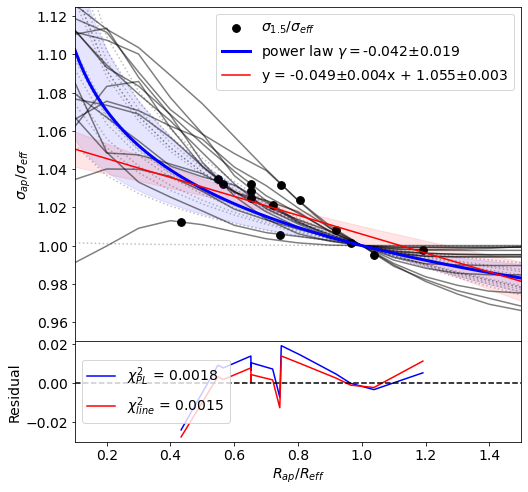

In [150]:
def power_law_fixed(x, a):
    return np.power(x, a)

# weighted
ps = np.zeros(14)
variances = np.zeros((14, 2))

aperture_ratios = 1.5/np.array(reffs)
sigma_ratios = VD_ap_int_rms_pixel_method_sdssap/VD_aperture
dsigma_ratios = sigma_ratios * np.sqrt((dVD_ap_int_rms_pixel_method_sdssap/VD_ap_int_rms_pixel_method_sdssap)**2 + (dVD_aperture/VD_aperture))

fig, axs = plt.subplots(2, 1, 
                        figsize=(8,8), 
                        sharex=True,
                        gridspec_kw={'height_ratios': [10, 3]})

plt.subplots_adjust(hspace=0.0)
for i in range(14):
    # plot the data
    axs[0].plot(reff_factors, VD_ratio[:,not_na][:,i], c='k', alpha=0.5)
    # weighted
    p, cov = curve_fit(f=power_law_fixed, xdata=reff_factors, ydata=VD_ratio[:,not_na][:,i], p0=[0], 
                       sigma=dVD_ratio[:,not_na][:,i], 
                       absolute_sigma=True,
                       bounds=(-np.inf, np.inf))
    ps[i] = p
    variances[i] = cov
    fit = power_law_fixed(reff_factors, p)
    axs[0].plot(reff_factors, fit, c='k', linestyle=':', alpha=0.25)
    # plot the ratios of kcwi - 1.5 to reff
    if i==0:
        axs[0].scatter(aperture_ratios[not_na][i], sigma_ratios[not_na][i], 
                        marker='o', c='k', s=60, label=r'$\sigma_{1.5}/\sigma_{eff}$')
    else:
        axs[0].scatter(aperture_ratios[not_na][i], sigma_ratios[not_na][i], marker='o', c='k', s=60)

# take the weighted mean of parameters for each fit # (weighted by inverse variance)
# weighted
mean = np.average(ps)#, weights=1/variances_w[:,0])
mean_var = np.average(variances)
mean_err = np.sqrt(mean_var/13)

print('pl weighted fit: mean', mean)

# plot the fit curve relation
x=np.linspace(0.1, 1.5, 100)
ac = unc.correlated_values(np.array([mean]), np.array([[mean_var]])) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = power_law_fixed(x, ac)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'power law $\gamma=${"{:.3f}".format(mean)}$\pm${"{:.3f}".format(np.sqrt(mean_var))}'
axs[0].plot(x, nom, c='b', linewidth=3, label=label)                            
# uncertainty lines (95% confidence)
axs[0].fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

            
# plot the linear correlation for aperture of 1.5 arcseconds
# linear fit
n_obj = len(aperture_ratios[not_na]) # number objects fit
p, cov = np.polyfit(aperture_ratios[not_na], sigma_ratios[not_na], deg=1, cov=True)
m=p[0]
b=p[1]
err =np.sqrt(np.diag(cov))/np.sqrt(n_obj)
merr = err[0]
berr = err[1]
print(m, b)
print(err)
# plot the linear relation
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label=f'y = {"{:.3f}".format(m)}$\pm${"{:.3f}".format(merr)}x + {"{:.3f}".format(b)}$\pm${"{:.3f}".format(berr)}'
axs[0].plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
axs[0].fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

    
axs[0].legend()
#axs[0].set_xlim(0.1, 1.5)
axs[1].set_xlabel(r'$R_{ap}/R_{eff}$')
axs[0].set_ylabel(r'$\sigma_{ap}/\sigma_{eff}$')
axs[1].set_xlim(0.1, 1.5)
axs[0].set_ylim(0.95, 1.125)
#axs[1].set_yticks(np.arange(0.0, 0.15, 0.05))
            
# residuals
sort = np.argsort(aperture_ratios[not_na])
curve_label = r'$\chi^2_{PL}$ = %.4f' % chi2_curve
line_label = r'$\chi^2_{line}$ = %.4f' % chi2_line
axs[1].plot(aperture_ratios[not_na][sort], residuals_curve[sort], c='b', label=curve_label)
axs[1].plot(aperture_ratios[not_na][sort], residuals_line[sort], c='r', label=line_label)
axs[1].axhline(0, 0, 1, color='k', linestyle='--')
axs[1].set_ylabel(r'Residual')
axs[1].legend(loc='center left')

#plt.savefig(f'{figure_dir}aperture_correction_power_law.png', bbox_inches='tight')
plt.savefig(f'{figure_dir}aperture_correction_power_law.pdf', bbox_inches='tight')

In [151]:
sigma_ratios[not_na]

array([1.0247153 , 1.03221039, 0.99793551, 1.00147098, 1.00820408,
       1.02370996, 1.02125391, 1.03228373, 1.0349616 , 0.99513664,
       1.02870352, 1.00543166, 1.031647  , 1.01209665])

In [152]:
aperture_ratios[not_na]

array([0.65275025, 0.65214677, 1.19155449, 0.9648539 , 0.91972852,
       0.80633136, 0.72046974, 0.56567973, 0.54865415, 1.03799619,
       0.65290615, 0.74281839, 0.74749709, 0.43331821])

# Characterize ratio of sigma_kcwi/sigma_sdss

In [153]:
SDSS_ap_ratios = VD_ap_int_rms_pixel_method_sdssap/VD_slacs_asb
dSDSS_ap_ratios = SDSS_ap_ratios*np.sqrt((dVD_ap_int_rms_pixel_method_sdssap/VD_ap_int_rms_pixel_method_sdssap)**2+(dVD_slacs_asb/VD_slacs_asb)**2)
np.mean(SDSS_ap_ratios)

0.9844492313485784

In [154]:
np.median(SDSS_ap_ratios)

0.9846094094564061

In [155]:
np.std(SDSS_ap_ratios)

0.09922547387165825

(array([1., 1., 4., 3., 3., 1., 0., 0., 0., 1.]),
 array([0.81728369, 0.86344442, 0.90960514, 0.95576587, 1.0019266 ,
        1.04808732, 1.09424805, 1.14040878, 1.1865695 , 1.23273023,
        1.27889096]),
 <BarContainer object of 10 artists>)

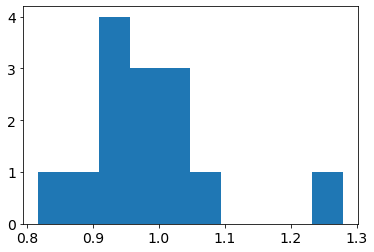

In [156]:
plt.hist(SDSS_ap_ratios)

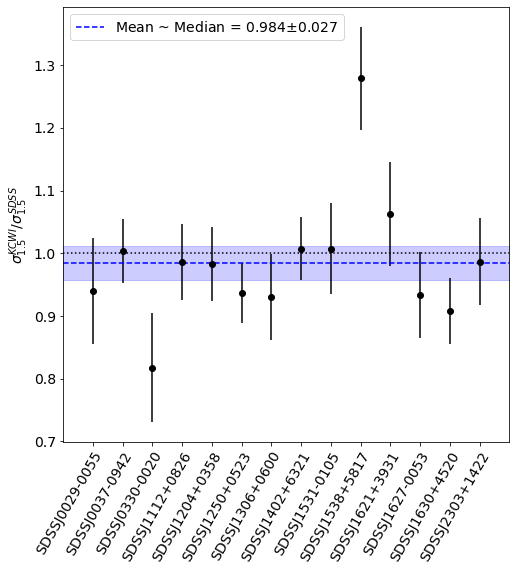

In [157]:
# plot the differences

mean = np.mean(SDSS_ap_ratios)
err = np.std(SDSS_ap_ratios)/np.sqrt(n_obj)

x = np.linspace(-1, 15, 100)
ylo = np.ones_like(x)*(mean-err)
yhi = np.ones_like(x)*(mean+err)

fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(VD_slacs_asb)):
    ax.errorbar(i, SDSS_ap_ratios[i], yerr=dSDSS_ap_ratios[i], color='k', marker='o')
ax.set_ylabel(r'${\sigma_{1.5''}^{KCWI}}/{\sigma_{1.5''}^{SDSS}}$')
ax.axhline(mean, 0, 1, color='b', linestyle='--', label=f'Mean ~ Median = {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(err)}')
ax.fill_between(x, 
                ylo,
               yhi,
               color='b',
               alpha=0.2)
ax.axhline(1.0, 0, 1, color='k', linestyle=':')
ax.set_xlim(-1, 14)
ax.set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax.legend(loc='upper left')

plt.savefig(f'{figure_dir}aperture_integrated_velocity_dispersions_within1pt5arcsec_{date}.pdf', bbox_inches='tight')
plt.savefig(f'{figure_dir}aperture_integrated_velocity_dispersions_within1pt5arcsec_{date}.png', bbox_inches='tight')

(170.0, 300.0)

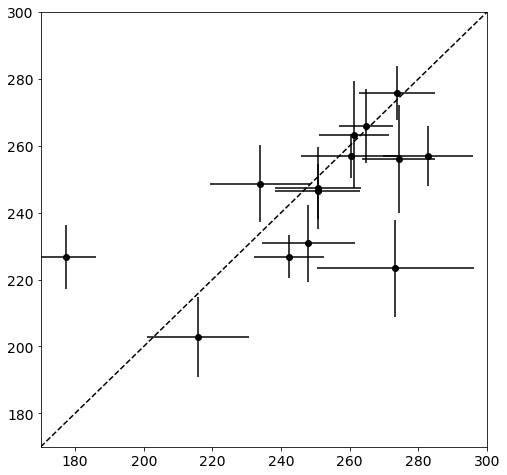

In [158]:
# plot the differences
x = np.linspace(170, 300, 100)
y = x

fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(VD_slacs_asb)):
    ax.errorbar(VD_slacs_asb[i], VD_ap_int_rms_pixel_method_sdssap[i], xerr=dVD_slacs_asb[i], yerr=dVD_ap_int_rms_pixel_method_sdssap[i], color='k', marker='o')
ax.plot(x, y, 'k--')
ax.set_ylim(170, 300)
ax.set_xlim(170, 300)

# Show the plot of the aperture integrated velocity dispersions and the ratio of 1.5 together



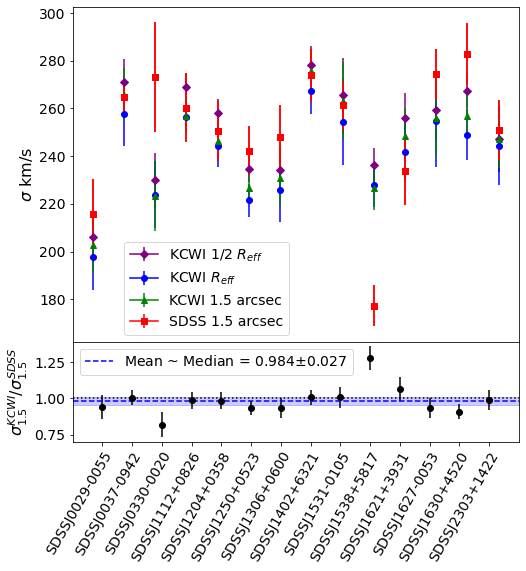

In [159]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(2,1,figsize=(8,8), gridspec_kw={'height_ratios': [10, 3]})
plt.subplots_adjust(hspace=0.0)

# plot the aperture integrated velocity dispersions

for i in range(14):
    ax[0].errorbar(i, VD_half_reff[i], yerr=dVD_half_reff[i], c='purple', marker='D')
    ax[0].errorbar(i, VD_ap_int_rms_pixel_method[i], yerr=dVD_ap_int_rms_pixel_method[i], c='b', marker='o')
    ax[0].errorbar(i, VD_ap_int_rms_pixel_method_sdssap[i], yerr=dVD_ap_int_rms_pixel_method_sdssap[i], c='g', marker='^')
    ax[0].errorbar(i, VD_slacs_asb[i], yerr=dVD_slacs_asb[i], c='r', marker='s')
#    plt.errorbar(i, sdss_sigmas[i], yerr=sdss_sigmas_err[i], c='r', marker='x', alpha=0.1)
    ax[0].errorbar(i, VD_slacs_asb[i], yerr=dVD_slacs_asb[i], c='r', marker='s')
    if i==0:
        ax[0].legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   bbox_to_anchor=(0.1,0.32))
ax[0].set_xticks([])#range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[0].set_ylabel(r'$\sigma$ km/s', fontsize=16)

# plot the differences

x = np.linspace(-1, 15, 100)
ylo = np.ones_like(x)*(mean-err)
yhi = np.ones_like(x)*(mean+err)

for i in range(len(VD_slacs_asb)):
    ax[1].errorbar(i, SDSS_ap_ratios[i], yerr=dSDSS_ap_ratios[i], color='k', marker='o')
ax[1].set_ylabel(r'${\sigma_{1.5''}^{KCWI}}/{\sigma_{1.5''}^{SDSS}}$', fontsize=16)
ax[1].axhline(mean, 0, 1, color='b', linestyle='--', label=f'Mean ~ Median = {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(err)}')
ax[1].fill_between(x, 
                ylo,
               yhi,
                color='b',
               alpha=0.2)
ax[1].axhline(1.0, 0, 1, color='k', linestyle=':')
ax[1].set_xlim(-1, 14)
ax[1].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[1].legend(loc='upper left')

#plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_within1pt5arcsec_{date}.pdf', bbox_inches='tight')
#plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_within1pt5arcsec_{date}.png', bbox_inches='tight')

#plt.tight_layout()
plt.savefig(f'{figure_dir}aperture_integrated_velocity_dispersions.pdf', bbox_inches='tight')

In [160]:
classifications.columns

Index(['Unnamed: 0', 'obj_name', 'class', 'subclass', 'comments',
       'ellipticity', 'V_sigma_mge', 'lambda_R_mge', 'PA_phot', 'delta_PA',
       'PA_kin', 'dPA_kin', 'oblate_prolate', 'SLACS delta_PA',
       'V_aperture_mge', 'VD_aperture_mge', 'dVD_aperture_mge',
       'Vrms_aperture_mge', 'SLACS VD', 'SLACS dVD', 'PA_kin_bspline',
       'dPA_kin_bspline', 'PA_phot_bspline', 'delta_PA_bspline',
       'ellipticity_bspline', 'kcwi_sigmapsf_bspline', 'reff_slacs_x',
       'ellipticity_slacs', 'reff_mge', 'reff_maj_mge', 'eps_reff_ellipse_mge',
       'luminosities_mge', 'reff_slacs_v', 'pa_slacs_v', 'VD_slacs_asb',
       'dVD_slacs_asb', 'V_sigma_bin', 'lambda_R_bin', 'D_ap_bin', 'dV_ap_bin',
       'VD_ap_bin', 'dVD_ap_bin', 'V_sigma_pix', 'lambda_R_pix', 'V_ap_pix',
       'dV_ap_pix', 'VD_ap_pix', 'dVD_ap_pix', 'V_aperture_mge.1',
       'VD_aperture_mge.1', 'Vrms_aperture_mge.1', 'V_sigma_class',
       'lambda_R_class', 'stellar_mass', 'V_aperture', 'VD_aperture',
       '

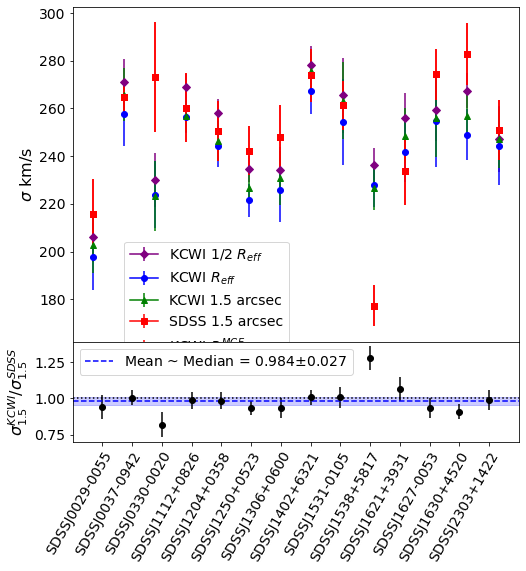

In [161]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(2,1,figsize=(8,8), gridspec_kw={'height_ratios': [10, 3]})
plt.subplots_adjust(hspace=0.0)

# plot the aperture integrated velocity dispersions

for i in range(14):
    ax[0].errorbar(i, VD_half_reff[i], yerr=dVD_half_reff[i], c='purple', marker='D')
    ax[0].errorbar(i, VD_ap_int_rms_pixel_method[i], yerr=dVD_ap_int_rms_pixel_method[i], c='b', marker='o')
    ax[0].errorbar(i, VD_ap_int_rms_pixel_method_sdssap[i], yerr=dVD_ap_int_rms_pixel_method_sdssap[i], c='g', marker='^')
    ax[0].errorbar(i, VD_slacs_asb[i], yerr=dVD_slacs_asb[i], c='r', marker='s')
   # ax[0].errorbar(i, classifications.loc[i, 'VD_aperture_mge'], yerr=classifications.loc[i, 'dVD_aperture'], c='orange', marker='*')
#    plt.errorbar(i, sdss_sigmas[i], yerr=sdss_sigmas_err[i], c='r', marker='x', alpha=0.1)
    ax[0].errorbar(i, VD_slacs_asb[i], yerr=dVD_slacs_asb[i], c='r', marker='s')
    if i==0:
        ax[0].legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec', 'KCWI $R_{eff}^{MGE}$'], 
                   bbox_to_anchor=(0.1,0.32))
ax[0].set_xticks([])#range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[0].set_ylabel(r'$\sigma$ km/s', fontsize=16)

# plot the differences

x = np.linspace(-1, 15, 100)
ylo = np.ones_like(x)*(mean-err)
yhi = np.ones_like(x)*(mean+err)

for i in range(len(VD_slacs_asb)):
    ax[1].errorbar(i, SDSS_ap_ratios[i], yerr=dSDSS_ap_ratios[i], color='k', marker='o')
ax[1].set_ylabel(r'${\sigma_{1.5''}^{KCWI}}/{\sigma_{1.5''}^{SDSS}}$', fontsize=16)
ax[1].axhline(mean, 0, 1, color='b', linestyle='--', label=f'Mean ~ Median = {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(err)}')
ax[1].fill_between(x, 
                ylo,
               yhi,
                color='b',
               alpha=0.2)
ax[1].axhline(1.0, 0, 1, color='k', linestyle=':')
ax[1].set_xlim(-1, 14)
ax[1].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[1].legend(loc='upper left')

#plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_within1pt5arcsec_{date}.pdf', bbox_inches='tight')
#plt.savefig(f'{data_dir}aperture_integrated_velocity_dispersions_within1pt5arcsec_{date}.png', bbox_inches='tight')

#plt.tight_layout()
#plt.savefig(f'{figure_dir}aperture_integrated_velocity_dispersions.pdf', bbox_inches='tight')

# 02/14/23
# Looking at the relations in SLACS X between:
## log(sigma_{reff/2}) and log(M_*)
## gamma and f_SIE
## gamma and reff
## gamma and sigma_{reff/2}
## gamma and M_{reff/2} / {reff^-2} ??? Maybe not this one
## M_{reff/2} and M*


In [162]:
import astropy.constants as c
import astropy.units as u

In [163]:
G_unit = c.G.to(u.kpc * u.km**2 / u.M_sun / u.s**2)

In [164]:
G_unit

<Quantity 4.30091727e-06 km2 kpc / (s2 solMass)>

In [165]:
# first take sigma_1/2 and the slacs-adjusted value from sigma_sdss

def VD_half_reff_from_sdss(VD_sdss, dVD_sdss, reff):
    '''
    This is the relation I derive from the power law fit to my KCWI measurements
    VD_sdss is the input 1.5 arcsec aperture velocity disperion
    error
    effective radius in arcsec
    '''
    # this is the gamma I get from the power law fit
    gamma = -0.036
    
    # reff/3 comes from the Reff/2 /1.5
    VD_half_reff = VD_sdss * np.power(reff/3, gamma)
    dVD_half_reff = dVD_sdss * np.power(reff/3, gamma)
    
    return VD_half_reff, dVD_half_reff

# function for calculating dynamical mass from SLACS X

def dynamical_mass_half_reff(reff_kpc, VD_half_reff, dVD_half_reff):
    
    'Virial estimate following prescription from slacs x'
    
    cv = 10**0.53 # virial coefficient fit SLACS X
    # G unit is the value of G in km2kpc/M⊙s2
    M_half_reff = (cv * reff_kpc.value * VD_half_reff**2) / (2 * G_unit.value)
    dM_half_reff = (2*dVD_half_reff/VD_half_reff) * M_half_reff
    return M_half_reff, dM_half_reff


In [166]:
# calculate half-reff velocity dispersions for updated SLACS info from Bolton
VD_sdss = np.array(VD_slacs_asb)#[not_na])
dVD_sdss = np.array(dVD_slacs_asb)#[not_na])

# use  slacs effective radii
#reffs = reffs#[not_na]
reffs_kpc = cosmo.angular_diameter_distance(zlens).to(u.kpc)*reffs/206265

# get half-reff velocity dispersions
VD_half_reff_sdss, dVD_half_reff_sdss = VD_half_reff_from_sdss(VD_sdss, dVD_sdss, reffs)
# take the kcwi info
VD_half_reff_kcwi = VD_half_reff#[not_na]
dVD_half_reff_kcwi = dVD_half_reff#[not_na]
# take logs
log_VD_half_reff_sdss = np.log10(VD_half_reff_sdss)
dlog_VD_half_reff_sdss = dVD_half_reff_sdss/VD_half_reff_sdss * 1/np.log(10)
log_VD_half_reff_kcwi = np.log10(VD_half_reff_kcwi)
dlog_VD_half_reff_kcwi = dVD_half_reff_kcwi/VD_half_reff_kcwi * 1/np.log(10)

# take log stellar masses from SLACS IX
log_stellar_masses = log_stellar_masses_salp#[not_na]-11 # they normalized inside the log to 10^11 solar masses
dlog_stellar_masses = dlog_stellar_masses_salp#[not_na]

# calculate dynamical mass within half effecitve radius
Mdyn_half_reff_kcwi, dMdyn_half_reff_kcwi = dynamical_mass_half_reff(reffs_kpc, VD_half_reff_kcwi, dVD_half_reff_kcwi)
Mdyn_half_reff_sdss, dMdyn_half_reff_sdss = dynamical_mass_half_reff(reffs_kpc, VD_half_reff_sdss, dVD_half_reff_sdss)
# logs
log_Mdyn_half_reff_kcwi = np.log10(Mdyn_half_reff_kcwi)
dlog_Mdyn_half_reff_kcwi = np.array(dMdyn_half_reff_kcwi/Mdyn_half_reff_kcwi) * 1/np.log(10)
dlog_Mdyn_half_reff_kcwi = np.array(dlog_Mdyn_half_reff_kcwi)
log_Mdyn_half_reff_sdss = np.log10(Mdyn_half_reff_sdss)
dlog_Mdyn_half_reff_sdss = np.array(dMdyn_half_reff_sdss/Mdyn_half_reff_sdss) * 1/np.log(10)
dlog_Mdyn_half_reff_sdss = np.array(dlog_Mdyn_half_reff_sdss)

In [167]:
Mdyn_half_reff_kcwi

array([1.39856298e+11, 2.15574433e+11, 1.29973380e+11, 1.84652062e+11,
       1.20301806e+11, 1.49055463e+11, 1.32169631e+11, 2.72046570e+11,
       2.09355093e+11, 7.99146166e+10, 2.28254251e+11, 1.81833900e+11,
       2.19928830e+11, 2.23576788e+11])

In [172]:
slacs_x_data = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data.txt', delimiter='')
slacs_x_names = np.genfromtxt(f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/tables/slacs_x_data_names.txt', delimiter='', dtype='U15')
# make a dataframe
slacs_x = pd.DataFrame(slacs_x_data,
                      columns=['obj_name',
                              'reff_kpc',
                              'VD_half_reff',
                              'dVD_half_reff',
                              'log_stellar_mass_chab',
                              'dlog_stellar_mass_chab',
                              'log_stellar_mass_salp',
                              'dlog_stellar_mass_salp',
                              'log_M_half_reff',
                              'dlog_M_half_reff',
                              'fdm_chab',
                              'dfdm_chab',
                               'fdm_salp',
                               'dfdm_salp',
                               'gamma',
                               'dgamma'
                              ])
slacs_x['obj_name']=slacs_x_names

slacs_x['log_VD_half_reff'] = np.log10(slacs_x['VD_half_reff'])
slacs_x['dlog_VD_half_reff'] = 1/np.log(10) * slacs_x['dVD_half_reff']/slacs_x['VD_half_reff']

In [173]:
slacs_x_names

array(['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ0044+0113',
       'SDSSJ0216-0813', 'SDSSJ0252+0039', 'SDSSJ0330-0020',
       'SDSSJ0728+3835', 'SDSSJ0737+3216', 'SDSSJ0819+4534',
       'SDSSJ0822+2652', 'SDSSJ0912+0029', 'SDSSJ0935-0003',
       'SDSSJ0936+0913', 'SDSSJ0946+1006', 'SDSSJ0956+5100',
       'SDSSJ0959+0410', 'SDSSJ0959+4416', 'SDSSJ1016+3859',
       'SDSSJ1020+1122', 'SDSSJ1023+4230', 'SDSSJ1029+0420',
       'SDSSJ1106+5228', 'SDSSJ1112+0826', 'SDSSJ1134+6027',
       'SDSSJ1142+1001', 'SDSSJ1143-0144', 'SDSSJ1153+4612',
       'SDSSJ1204+0358', 'SDSSJ1205+4910', 'SDSSJ1213+6708',
       'SDSSJ1218+0830', 'SDSSJ1250+0523', 'SDSSJ1306+0600',
       'SDSSJ1313+4615', 'SDSSJ1318-0313', 'SDSSJ1330-0148',
       'SDSSJ1402+6321', 'SDSSJ1403+0006', 'SDSSJ1416+5136',
       'SDSSJ1420+6019', 'SDSSJ1430+4105', 'SDSSJ1436-0000',
       'SDSSJ1443+0304', 'SDSSJ1451-0239', 'SDSSJ1525+3327',
       'SDSSJ1531-0105', 'SDSSJ1538+5817', 'SDSSJ1614+4522',
       'SDSSJ1621+3931',

# plot log sigma_reff/2 to log stellar mass
# velocity dispersion in units km/s and stellar mass in units 10^11 solar masses

mean std,  0.03996561753096395
my calculation:  0.1888346663513771 0.039769567088716665 2.2947368044044043 0.024934600425686976
slacs x values:  0.18 0.03 2.34 0.01


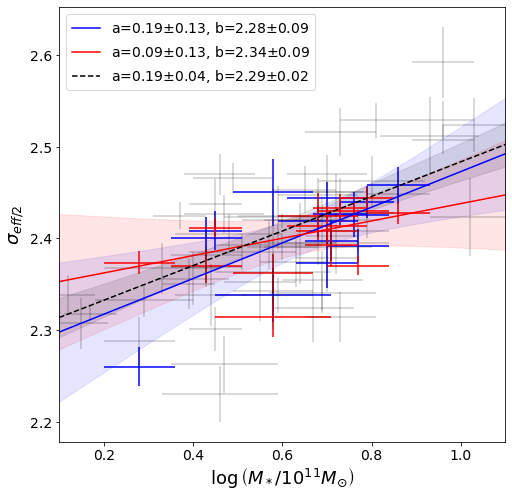

In [176]:
# log stellar masses from SLACS IX

fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(log_stellar_masses[not_na]-11, log_VD_half_reff_sdss[not_na],
            xerr=dlog_stellar_masses[not_na], yerr=dlog_VD_half_reff_sdss[not_na], 
             color='b',
            linestyle='')
axs.errorbar(log_stellar_masses[not_na]-11, log_VD_half_reff_kcwi[not_na],
            xerr=dlog_stellar_masses[not_na], yerr=dlog_VD_half_reff_kcwi[not_na], 
             color='r',
            linestyle='')
axs.errorbar(slacs_x['log_stellar_mass_salp']-11, slacs_x['log_VD_half_reff'],
            xerr=slacs_x['dlog_stellar_mass_salp'], yerr=slacs_x['dlog_VD_half_reff'], 
             color='k',
            #marker='.',
            linestyle='',
            alpha=0.2
            )

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(log_stellar_masses[not_na]-11, log_VD_half_reff_sdss[not_na],
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_sdss[not_na]**2+dlog_stellar_masses[not_na]**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
                 
# fit a line to kcwi data
p, cov = np.polyfit(log_stellar_masses[not_na]-11, log_VD_half_reff_kcwi[not_na],
                    deg=1,
                    w=1/np.sqrt(dlog_VD_half_reff_kcwi[not_na]**2+dlog_stellar_masses[not_na]**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
x = np.linspace(0.1, 1.1, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
print('mean std, ', np.mean(std))
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
                 
# slacs x lines
# a = 0.18±0.03, b = 2.34±0.01
# do a fit and see if it's the same
p, cov = np.polyfit(slacs_x['log_stellar_mass_salp']-11, slacs_x['log_VD_half_reff'],
                    deg=1,
                    w=1/np.sqrt(slacs_x['dlog_stellar_mass_salp']**2+slacs_x['dlog_VD_half_reff']**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
print('my calculation: ', m, merr, b, berr)
m_x = 0.18
merr_x = 0.03
b_x = 2.34
berr_x = 0.01
print('slacs x values: ', m_x, merr_x, b_x, berr_x)
x = np.linspace(0.1, 1.1,100)
#p = np.array([m,b])
#cov = np.array([[merr, 0],
#              [0, berr]]) # no info on the covriance
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='k', linestyle='--', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
                 
axs.set_xlim(0.1, 1.1)
label_fontsize=18
axs.set_xlabel(r'$\log\left(M_*/10^{11}M_{\odot}\right)$', fontsize=label_fontsize)
axs.set_ylabel(r'$\sigma_{eff/2}}$', fontsize=label_fontsize)
axs.legend()

plt.savefig(f'{figure_dir}slacs_x_analysis/VD_half_reff_vs_log_stellar_mass.pdf', bbox_inches='tight')

# Plot log(M*) to log(M_{reff/2})
# units both in solar masses

my calculation:  0.8057778729432392 0.0346699729421865 2.541377125054016 0.3883938429078394
slacs x values:  0.81 0.03 2.292221270567608 0.3026549190084311


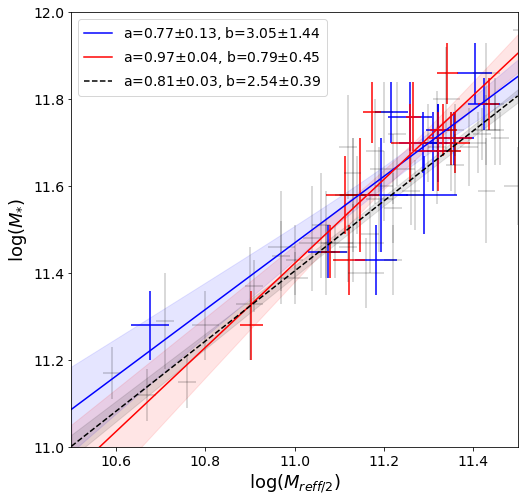

In [177]:
fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(log_Mdyn_half_reff_sdss[not_na], log_stellar_masses[not_na],
            xerr=dlog_Mdyn_half_reff_sdss[not_na], yerr=dlog_stellar_masses[not_na], 
             color='b',
            linestyle='')
axs.errorbar(log_Mdyn_half_reff_kcwi[not_na], log_stellar_masses[not_na],
            xerr=dlog_Mdyn_half_reff_kcwi[not_na], yerr=dlog_stellar_masses[not_na], 
             color='r',
            linestyle='')
axs.errorbar(slacs_x['log_M_half_reff'], slacs_x['log_stellar_mass_salp'],
            xerr=slacs_x['dlog_M_half_reff'], yerr=slacs_x['dlog_stellar_mass_salp'], 
             color='k',
            #marker='.',
            linestyle='',
            alpha=0.2
            )

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(log_Mdyn_half_reff_sdss[not_na], log_stellar_masses[not_na],
                    deg=1,
                    w=1/np.sqrt(dlog_Mdyn_half_reff_sdss[not_na]**2+dlog_stellar_masses[not_na]**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
x = np.linspace(10.5,11.5, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)

# fit a line to kcwi data
p, cov = np.polyfit(log_Mdyn_half_reff_kcwi[not_na], log_stellar_masses[not_na], 
                    deg=1,
                    w=1/np.sqrt(dlog_Mdyn_half_reff_kcwi[not_na]**2+dlog_stellar_masses[not_na]**2),
                    cov='unscaled'
                   )
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
x = np.linspace(10.5,11.5,100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std, 
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )

# slacs x lines
# a = 0.18±0.03, b = 2.34±0.01
# do a fit and see if it's the same
p, cov = np.polyfit(slacs_x['log_M_half_reff'], slacs_x['log_stellar_mass_salp'],
                    deg=1,
                    w=1/np.sqrt(slacs_x['dlog_stellar_mass_salp']**2+slacs_x['dlog_M_half_reff']**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
merr = err[0]
berr = err[1]
print('my calculation: ', m, merr, b, berr)
m_x = 0.81
merr_x = 0.03
bb_x = 0.35
bberr_x = 0.04
b_x = (1-m)*10 + bb_x
berr_x = np.sqrt((10*merr_x)**2+bberr_x**2)
print('slacs x values: ', m_x, merr_x, b_x, berr_x)
x = np.linspace(10.5,11.5,100)
#p = np.array([m,b])
#cov = np.array([[merr, 0],
#              [0, berr]]) # no info on the covriance
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='k', linestyle='--', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std, 
                 color='k',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
axs.set_xlabel(r'$\log(M_{{reff}/2})$', fontsize=label_fontsize)
axs.set_ylabel(r'$\log(M_{*})$', fontsize=label_fontsize)
axs.set_xlim(10.5,11.5)
axs.set_ylim(11.0,12.0)
axs.legend()

plt.savefig(f'{figure_dir}slacs_x_analysis/log_stellar_mass_vs_log_M_half_reff.pdf', bbox_inches='tight')

# Need gamma and einstein radii from Shajib 2020 https://arxiv.org/pdf/2008.11724.pdf
# Then calculate the SIE velocity dispersion as $\sigma_{SIE}= c/2 \sqrt{\theta_E/\pi D_{LS}/D_S}$
# Redshifts from SLACS IX

In [178]:
# gammas
gammas = np.array([2.47,
                 2.18,
                 2.16,
                 2.21,
                 2.19,
                 1.91,
                 2.18,
                 2.24,
                 1.90,
                 np.nan,
                 2.01,
                 1.84,
                 2.00,
                 2.00
                 ])
dgammas = np.array([0.08,
                     0.04,
                     0.02,
                     0.06,
                     0.06,
                     0.06,
                     0.06,
                     0.07,
                     0.12,
                     np.nan,
                     0.06,
                     0.14,
                     0.03,
                     0.05
                     ])

# einstein radii
reins = np.array([0.951,
                1.509,
                1.077,
                1.421,
                 1.285,
                 1.115,
                 1.299,
                 1.354,
                 1.705,
                 np.nan,
                 1.263,
                 1.227,
                 1.788,
                 1.529
                ])
dreins = np.array([0.003,
                  0.020,
                  0.005,
                  0.015,
                  0.005,
                  0.004,
                  0.012,
                  0.003,
                  0.009,
                 np.nan,
                  0.005,
                  0.002,
                  0.006,
                  0.005
                  ])

# index for the one that doesn't have a lens model (in Shajib 2020)
no_lens = np.isfinite(reins)
nnnl = not_na & no_lens

def VD_sie_from_rein_redshifts(rein, drein, zlens, zsource):
    
    DS = cosmo.angular_diameter_distance(zsource)
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource)
    
    c_kms = c.c.to(u.km/u.s).value
    rein_rad = rein/206265    
    
    VD_sie = c_kms/2 * np.sqrt((rein_rad/np.pi)*(DLS/DS))
    dVD_sie = VD_sie * 1/2 * drein / rein # the ratio will take care of the unit change
    
    return(VD_sie, dVD_sie)

def VD_sie_from_rein_kpc_redshifts(rein_kpc, zlens, zsource):
    
    DS = cosmo.angular_diameter_distance(zsource)
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource)
    DL = cosmo.angular_diameter_distance(zlens)
    
    c_kms = c.c.to(u.km/u.s).value
    rein_rad = rein_kpc/(DL*1000) #Mpc to kpc # already in radians
    
    # assume some kind of uncertainty here... 5% ?
    drein = 0.05 * rein_rad
    
    VD_sie = c_kms/2 * np.sqrt((rein_rad/np.pi)*(DLS/DS))
    dVD_sie = VD_sie * 1/2 * drein / rein_rad # I know this is redundant
    
    return(VD_sie, dVD_sie)

def f_sie_from_VDs(VD_half_reff, dVD_half_reff, VD_sie, dVD_sie):
    
    f_sie = VD_half_reff / VD_sie
    df_sie = np.sqrt( (dVD_half_reff/VD_half_reff)**2 + (dVD_sie/VD_sie)**2 )
    
    return f_sie, df_sie

# now calculate the SIE velocity dispersion for each set of data

VD_sies, dVD_sies = VD_sie_from_rein_redshifts(reins, dreins, zlens, zsource)
f_sies_kcwi, df_sies_kcwi = f_sie_from_VDs(VD_half_reff_kcwi, dVD_half_reff_kcwi, VD_sies, dVD_sies)
f_sies_sdss, df_sies_sdss = f_sie_from_VDs(VD_half_reff_sdss, dVD_half_reff_sdss, VD_sies, dVD_sies)

VD_sies_slacs_x, dVD_sies_slacs_x = VD_sie_from_rein_kpc_redshifts(slacs_ix['rein_kpc'], slacs_ix['zlens'], slacs_ix['zsource'])
slacs_x['VD_sie'] = VD_sies_slacs_x
slacs_x['dVD_sie'] = dVD_sies_slacs_x
f_sies_slacs_x, df_sies_slacs_x = f_sie_from_VDs(slacs_x['VD_half_reff'], slacs_x['dVD_half_reff'], slacs_x['VD_sie'], slacs_x['dVD_sie'])
slacs_x['f_sie'] = f_sies_slacs_x
slacs_x['df_sie'] = df_sies_slacs_x

# Function to calculate the total surface potential sigma_tot = M_reff/2 / reff^2
def sigma_tot_from_mass_half_reff_and_reff_sq (Mdyn_half_reff, dMdyn_half_reff, reff_kpc):
    
    Sigma_tot = Mdyn_half_reff / (reff_kpc)**2
    dSigma_tot = dMdyn_half_reff / (reff_kpc)**2
    
    return Sigma_tot, dSigma_tot

# calculate the surface potential for each (# I think the SLACS X plot and table are NOT logarithmic.)

Sigma_tots_kcwi, dSigma_tots_kcwi = sigma_tot_from_mass_half_reff_and_reff_sq (Mdyn_half_reff_kcwi, dMdyn_half_reff_kcwi, reffs_kpc.value)
Sigma_tots_sdss, dSigma_tots_sdss = sigma_tot_from_mass_half_reff_and_reff_sq (Mdyn_half_reff_sdss, dMdyn_half_reff_sdss, reffs_kpc.value)
#log_Sigma_tots_kcwi = np.log10(Sigma_tots_kcwi)
#dlog_Sigma_tots_kcwi = (dSigma_tots_kcwi/Sigma_tots_kcwi) * 1/np.log(10)
#log_Sigma_tots_sdss = np.log10(Sigma_tots_sdss)
#dlog_Sigma_tots_sdss = (dSigma_tots_sdss/Sigma_tots_sdss) * 1/np.log(10)

Sigma_tots_slacs_x, dSigma_tots_slacs_x = sigma_tot_from_mass_half_reff_and_reff_sq(10**slacs_x['log_M_half_reff'], 
                                                                                    10**slacs_x['dlog_M_half_reff'],
                                                                                   slacs_x['reff_kpc'])
slacs_x['surface_mass_density'] = Sigma_tots_slacs_x
slacs_x['dsurface_mass_density'] = dSigma_tots_slacs_x
#log_Sigma_tots_slacs_x = np.log10(Sigma_tots_slacs_x)
#dlog_Sigma_tots_slacs_x = dSigma_tots_slacs_x/Sigma_tots_slacs_x * 1/(np.log(10))

# Plot gamma to f_sie
# Don't use SLACS X data here
# units dimensionless

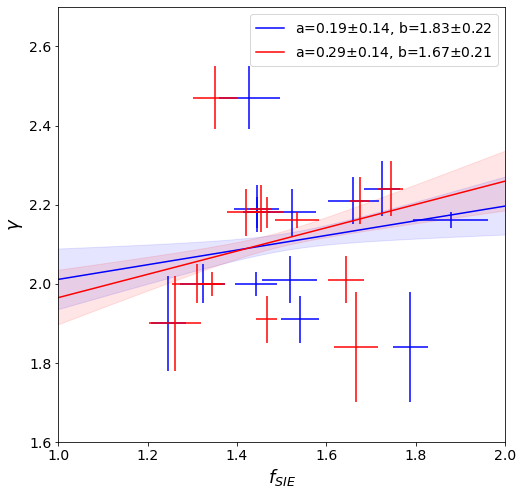

In [179]:
fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(f_sies_sdss[nnnl], gammas[nnnl], 
            xerr=df_sies_sdss[nnnl], yerr=dgammas[nnnl], 
             color='b',
            linestyle='')
axs.errorbar(f_sies_kcwi[nnnl], gammas[nnnl], 
            xerr=df_sies_kcwi[nnnl], yerr=dgammas[nnnl], 
             color='r',
            linestyle='')

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(f_sies_sdss[nnnl], gammas[nnnl],
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+df_sies_sdss[nnnl]**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(1, 3, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)


# fit a line
p, cov = np.polyfit(f_sies_kcwi[nnnl], gammas[nnnl], 
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+df_sies_kcwi[nnnl]**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(1, 3, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)



axs.set_xlim(1.0,2.0)
axs.set_ylim(1.6, 2.7)
axs.set_xlabel(r'$f_{SIE}$', fontsize=label_fontsize)#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_ylabel(r'$\gamma$', fontsize=label_fontsize)
axs.legend(loc='upper right')

plt.savefig(f'{figure_dir}slacs_x_analysis/gamma_vs_f_sie.pdf', bbox_inches='tight')

# Plot gamma to VD in half effective radius
# units 200 km/s for fit, plot with km/s

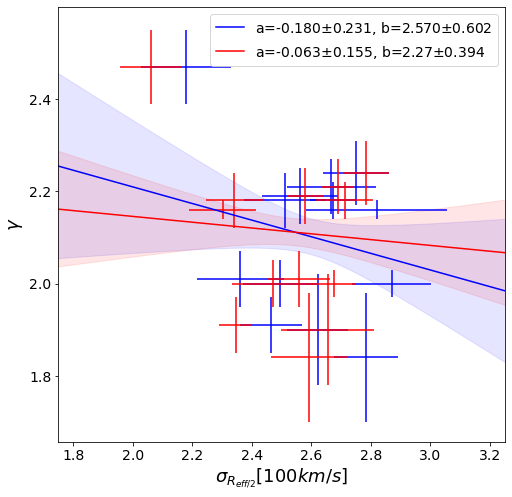

In [180]:
fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(VD_half_reff_sdss[nnnl]/100, gammas[nnnl], # units of 100 km/s
            xerr=dVD_half_reff_sdss[nnnl]/100, yerr=dgammas[nnnl], 
             color='b',
            linestyle='')
axs.errorbar(VD_half_reff_kcwi[nnnl]/100, gammas[nnnl], 
            xerr=dVD_half_reff_kcwi[nnnl]/100, yerr=dgammas[nnnl], 
             color='r',
            linestyle='')

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(VD_half_reff_sdss[nnnl]/100, gammas[nnnl], # units of 100 km/s
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+(dVD_half_reff_sdss[nnnl]/100)**2),
                    cov='unscaled'
                   )
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(1.50, 3.50, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = (ac*x+bc) 
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.3f}".format(m)}$\pm${"{:.3f}".format(merr)}, b={"{:.3f}".format(b)}$\pm${"{:.3f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)


# fit a line
p, cov = np.polyfit(VD_half_reff_kcwi[nnnl]/100, gammas[nnnl], # units of 100 km/s
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+(dVD_half_reff_kcwi[nnnl]/100)**2),
                    cov='unscaled'
                   )
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))#/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(1.50, 3.50, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = (ac*x+bc)
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.3f}".format(m)}$\pm${"{:.3f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.3f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)




axs.set_xlim(1.75, 3.25)
axs.set_xlabel(r'$\sigma_{R_{{eff}/2}}[100 km/s]$', fontsize=label_fontsize)#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_ylabel(r'$\gamma$', fontsize=label_fontsize)
axs.legend()

plt.savefig(f'{figure_dir}slacs_x_analysis/gamma_vs_VD_half_reff.pdf', bbox_inches='tight')

# The gamma-VD is not very significant according to SLACS X.
# Now plot gamma to Sigma_tot = M_reff/2 / reff^2
# Do it with density units of 10^11 Msol / kpc^2

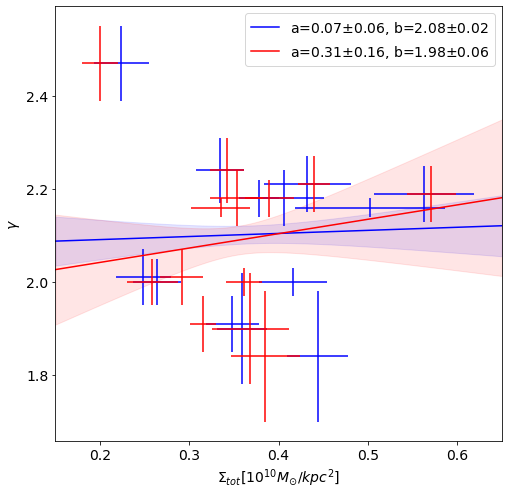

In [181]:
fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(Sigma_tots_sdss[nnnl]/10**10, gammas[nnnl], 
            xerr=dSigma_tots_sdss[nnnl]/10**10, yerr=dgammas[nnnl], 
             color='b',
            linestyle='')
axs.errorbar(Sigma_tots_kcwi[nnnl]/10**10, gammas[nnnl], 
            xerr=dSigma_tots_kcwi[nnnl]/10**10, yerr=dgammas[nnnl], 
             color='r',
            linestyle='')

# fit a line to sdss data
# fit a line
p, cov = np.polyfit(Sigma_tots_sdss[nnnl]/10**10, gammas[nnnl],
                    deg=1,
                    w=1/np.sqrt(dgammas[nnnl]**2+(dSigma_tots_sdss[nnnl]/10**10)**2),
                    cov='unscaled')
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(0.15, 0.65, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='b', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='b',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)

# fit a line
p, cov = np.polyfit(Sigma_tots_kcwi[nnnl]/10**10, gammas[nnnl], 
                    deg=1,
                    w=1/(dgammas[nnnl]**2+(dSigma_tots_kcwi[nnnl]/10**10)**2),
                    cov=True)
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(0.15, 0.65, 100)
# calculate parameter confidence interval
ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
# calculate regression confidence interval
y = ac*x+bc
nom = unp.nominal_values(y) # the value of the fit
std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
# plot the regression
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
plt.plot(x, nom, c='r', label=label)
# uncertainty lines (95% confidence)
plt.fill_between(x, nom - std, nom + std,
                 color='r',
                 alpha=0.1#,\
         #label='95% Confidence Region'
                )
#plt.plot(px, nom + 1.96 * std, c='orange')
#xs.fill_between(x, ylo, yhi, 
#                color='k',
#               alpha=0.1)



axs.set_xlim(0.15, 0.65)
axs.set_xlabel(r'$\Sigma_{tot}[10^{10}M_{\odot}/kpc^2]}$')#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_ylabel(r'$\gamma$')
axs.legend()

plt.savefig(f'{figure_dir}slacs_x_analysis/gamma_vs_surface_mass_density.pdf')

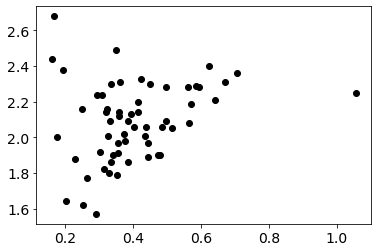

In [182]:
# How it looks for SLACS X
plt.scatter(slacs_x['surface_mass_density']/(10**10), slacs_x['gamma'], color='k')

# 2/17/13 - I want to see if the linear relation for the aperture size works for 0.5, 1.0 arcsec, 2.0 arcsec

In [184]:
# plug in the extra steps of doing the integral over luminosity weighted pixels instead of just the bins. Will be more spatially accurate as an aperture of radius reff

ap_sizes = np.array([0.25,
                     0.5,
                     0.75,
                     1.0,
                     1.25,
                     1.5,
                    1.75,
                    2.0
                    ])


V_sigmas_pixel_method_aptest3 = np.zeros((len(ap_sizes), len(obj_names)))
lambda_Rs_pixel_method_aptest3 = np.zeros((len(ap_sizes), len(obj_names)))
V_ap_int_rms_pixel_method_aptest3 = np.zeros((len(ap_sizes), len(obj_names)))
VD_ap_int_rms_pixel_method_aptest3 = np.zeros((len(ap_sizes), len(obj_names)))
dV_ap_int_rms_pixel_method_aptest3 = np.zeros((len(ap_sizes), len(obj_names)))
dVD_ap_int_rms_pixel_method_aptest3 = np.zeros((len(ap_sizes), len(obj_names)))


for i, obj_name in enumerate(obj_names):
    
    print('Object ' + obj_name)
    #################
    # set up directories
    obj_abbr = obj_name[4:9] # e.g. J0029
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'
    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    save_dir = f'{dir}{obj_name}_systematics/'

    #################
    # get velocity and bin data 
    VD=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_VD_binned.txt',
             delimiter=',')
    VD_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_VD.txt',
                     delimiter=',')
    dVD = np.sqrt(np.diagonal(VD_cov))
    V=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_V_binned.txt',
                     delimiter=',')
    # subtract the mean V
    V = V - np.mean(V)
    V_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_V.txt',
                     delimiter=',')
    dV = np.sqrt(np.diagonal(V_cov))
    
    # import voronoi binning data (#bins, 5215), spectrum for each bin
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    num_bins = len(voronoi_binning_data)
    # import pixel data for bins
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
    
    #################
    # sum each bin across all wavelengths to get bin luminosities
    bin_luminosities = np.zeros(len(V))
    for j in range(len(V)):
        lum = np.sum(voronoi_binning_data[j])
        bin_luminosities[j] = lum
        
       
    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)


    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for j in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[j,0])
        y = int(vorbin_pixels[j,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[j] = pixel_luminosity
        
    #################
    # get mean R for each bin by pixel positions
    short_name = obj_name[4:]
    R = calc_R (vorbin_pixels, len(V))
    #print(f'length before cutting... {len(R)}')
    effective_radius = reffs[i]

    # loop through the different apertures    
    for k, ap_size in enumerate(ap_sizes):
        # calculate luminosity weights for each bin contribution to the integrated velocities within the effective radius
        shells=[1.]
        luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, 
                                                               num_bins, 
                                                               bin_luminosities, 
                                                               pixel_luminosities, 
                                                               shells, 
                                                               ap_size)

        # calculate the luminosity-weighted mean V and VD for the aperture within the effective radius
        sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
        normalized_lum_weights = luminosity_weights / sum_lum_weights

        # calculate V_sigma# calculate lambda_R
        V_sigmas_pixel_method_aptest3[k,i], \
            lambda_Rs_pixel_method_aptest3[k,i], \
            V_ap_int_rms_pixel_method_aptest3[k,i], \
            VD_ap_int_rms_pixel_method_aptest3[k,i], \
            dV_ap_int_rms_pixel_method_aptest3[k,i], \
            dVD_ap_int_rms_pixel_method_aptest3[k,i]  = calc_aperture_velocities_from_lum_weight_pixels(vorbin_pixels, 
                                                                                                         V, VD, dV, dVD, 
                                                                                                         pixel_luminosities, 
                                                                                                         ap_size)

    



Object SDSSJ0029-0055
Object SDSSJ0037-0942
Object SDSSJ0330-0020
Object SDSSJ1112+0826
Object SDSSJ1204+0358
Object SDSSJ1250+0523
Object SDSSJ1306+0600
Object SDSSJ1402+6321
Object SDSSJ1531-0105
Object SDSSJ1538+5817
Object SDSSJ1621+3931
Object SDSSJ1627-0053
Object SDSSJ1630+4520
Object SDSSJ2303+1422


In [185]:
VD_ap_int_rms_pixel_method_aptest3[0]

array([210.24256317, 286.56651053, 232.73868153, 282.48176938,
       261.26173765, 247.83723828, 243.97977946, 287.63048444,
       282.49468587, 238.87256315, 268.72640243, 271.78307991,
       278.8143233 , 242.87195682])

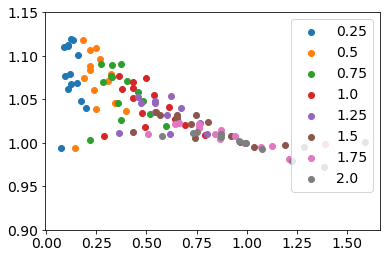

In [186]:
ap_ratios = np.zeros((len(ap_sizes), len(obj_names))) # different names so i don't overwrite what I have
sig_ratios = np.zeros((len(ap_sizes), len(obj_names)))
dsig_ratios = np.zeros((len(ap_sizes), len(obj_names)))

for j, ap in enumerate(ap_sizes):
    for i in range(len(obj_names)):

        ap_rat = ap/np.array(reffs[i])
        ap_ratios[j,i] = ap_rat
        sig_rat = VD_ap_int_rms_pixel_method_aptest3[j,i]/VD_aperture[i]
        sig_ratios[j,i] = sig_rat
        dsig_rat = sig_rat * np.sqrt((dVD_ap_int_rms_pixel_method_aptest3[j,i]/VD_ap_int_rms_pixel_method_aptest3[j,i])**2 + (dVD_aperture[i]/VD_aperture[i]))
        dsig_ratios[j,i] = dsig_rat

    plt.scatter(ap_ratios[j,:], sig_ratios[j,:], label=str(ap))
    
plt.ylim(0.9,1.15)
plt.legend()

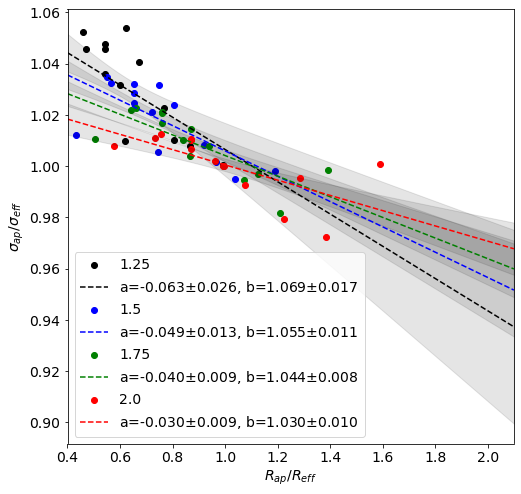

In [187]:
cmap = get_cmap(14)

plt.figure(figsize=(8,8))
for j in range(4,8):
    plt.scatter(ap_ratios[j,:][not_na], sig_ratios[j,:][not_na], 
                color=colors[j-4],
                label=str(ap_sizes[j])
               )
    p, cov = np.polyfit(ap_ratios[j,:][not_na], sig_ratios[j,:][not_na],
                       deg=1,
                       cov=True)
    m = p[0]
    b = p[1]
    err = np.sqrt(np.diag(cov))#/np.sqrt(len(log_stellar_masses[not_na]))
    merr = err[0]
    berr = err[1]
    x = np.linspace(0.4, 2.1, 100)
    # calculate parameter confidence interval
    ac,bc = unc.correlated_values(p, cov) # This accounts for the covariance terms so that it gives the proper std at each x for the confidence band
    # calculate regression confidence interval
    y = ac*x+bc
    nom = unp.nominal_values(y) # the value of the fit
    std = unp.std_devs(y)#/np.sqrt(len(log_stellar_masses[not_na])) # std at each x, makes the curve
    # plot the regression
    label = f'a={"{:.3f}".format(m)}$\pm${"{:.3f}".format(merr)}, b={"{:.3f}".format(b)}$\pm${"{:.3f}".format(berr)}'
    plt.plot(x, nom, color=colors[j-4], linestyle='--', label=label)
    # uncertainty lines (95% confidence)
    plt.fill_between(x, nom - std, nom + std, 
                     color='k',
                     alpha=0.1#,\
             #label='95% Confidence Region'
                    )
    
plt.legend()
plt.xlim(0.4, 2.1)
plt.xlabel(r'$R_{ap}/R_{eff}$')
plt.ylabel(r'$\sigma_{ap}/\sigma_{eff}$')

plt.savefig(f'{figure_dir}sigma_ratio_for_several_radii.pdf')

# 2/17/13 - Look at effective radii from Anowar Shajib 2020

In [155]:
anowar_reff_table = np.genfromtxt(f'{table_dir}anowar_reff.txt',
                           delimiter='',
                           dtype='U15',
                           skip_header=True
                           )
# make dataframe
anowar_reff = pd.DataFrame(anowar_reff_table,
                           columns=['obj_name',
                                   'anowar_reff',
                                   'danowar_reff'
                                   ]
                          )

classifications = pd.merge(classifications, anowar_reff, how='left', on='obj_name')

In [156]:
classifications['anowar_reff'] = classifications['anowar_reff'].astype(float)
classifications['danowar_reff'] = classifications['danowar_reff'].astype(float)

In [157]:
in_anowar = ~classifications['anowar_reff'].isna()

In [158]:
slacs_x_sample = slacs_x[slacs_x['obj_name'].isin(obj_names)].reset_index()
slacs_x_sample = slacs_x_sample.drop(columns='index')

In [161]:
slacs_x_sample['reff_kpc']/(DL*1000)*206265

0     2.297969
1     2.300096
2     1.258860
3     1.554640
4     1.630916
5     1.860277
6     2.081975
7     2.651677
8     2.733963
9     1.445092
10    2.297421
11    2.019336
12    2.006697
13    3.461659
Name: reff_kpc, dtype: float64

In [167]:
slacs_x_sample['reff_kpc']/(DL*1000)*206265/classifications['reff_mge']

0     1.075925
1     1.067633
2     0.957879
3     1.190447
4     1.570130
5     1.555395
6    -2.081975
7     1.398579
8     1.253112
9     0.967233
10    1.296623
11    1.275037
12    1.652971
13    1.457424
dtype: float64

0.16941504776705774
0.4153829728756937


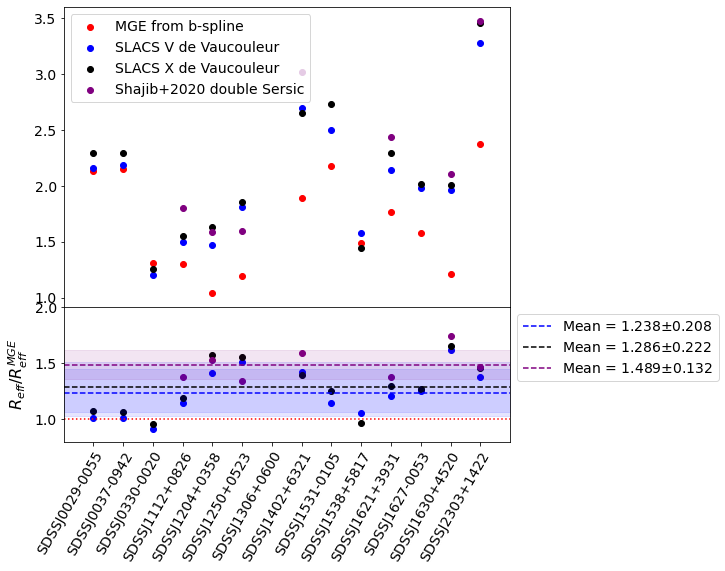

In [179]:
fig, ax = plt.subplots(2,1, figsize=(8,8), sharex=True, gridspec_kw={'height_ratios': [10, 4.5]})
plt.subplots_adjust(hspace=0.0)

for i in range(len(obj_names)):
    if not_na[i]:
        ax[0].scatter(i, classifications.loc[i, 'reff_mge'], c='r', label='MGE from b-spline')
        ax[0].scatter(i, classifications.loc[i, 'reff_slacs_v'], c='b', label='SLACS V de Vaucouleur')
        ax[0].scatter(i, slacs_x_sample.loc[i, 'reff_kpc']/(DL[i]*1000)*206265, c='k', label='SLACS X de Vaucouleur')
    if (in_anowar[i]) & (not_na[i]):
        ax[0].scatter(i, classifications.loc[i, 'anowar_reff'], color='purple', label='Shajib+2020 double Sersic')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles=handles[13:17],
              labels=labels[13:17],
              #labelcolor=['k','r','b'],
                   loc='upper left')
    
ax[0].set_xticks([])

# Now show ratios
ratio_slacs_kcwi = classifications.loc[not_na, 'reff_slacs_v']/classifications.loc[not_na, 'reff_mge']
ratio_slacsx_kcwi = slacs_x_sample.loc[not_na, 'reff_kpc']/(DL[not_na]*1000)*206265/classifications.loc[not_na, 'reff_mge']
ratio_anowar_kcwi = classifications.loc[(not_na)&(in_anowar), 'anowar_reff']/classifications.loc[(not_na)&(in_anowar), 'reff_mge']
mean_rat_slacs = np.mean(ratio_slacs_kcwi)
std_rat_slacs = np.std(ratio_slacs_kcwi)
mean_rat_slacsx = np.mean(ratio_slacsx_kcwi)
std_rat_slacsx = np.std(ratio_slacsx_kcwi)
mean_rat_anowar = np.mean(ratio_anowar_kcwi)
std_rat_anowar = np.std(ratio_anowar_kcwi)
ax[1].axhline(1.0, 0, 1, color='r', linestyle=':')
for i in range(len(obj_names)):
    if not_na[i]:
        ax[1].scatter(i, ratio_slacs_kcwi[i], color='b', marker='o')
        ax[1].scatter(i, ratio_slacsx_kcwi[i], color='k', marker='o')
    if (in_anowar[i])  & (not_na[i]):
        ax[1].scatter(i, ratio_anowar_kcwi[i], color='purple', marker='o')
ax[1].set_ylabel(r'${R_{eff}}/{R_{eff}^{MGE}}$', fontsize=16)
ax[1].axhline(mean_rat_slacs, 0, 1, color='b', linestyle='--', 
              label=f'Mean = {"{:.3f}".format(mean_rat_slacs)}$\pm${"{:.3f}".format(std_rat_slacs)}')
ax[1].axhline(mean_rat_slacsx, 0, 1, color='k', linestyle='--', 
              label=f'Mean = {"{:.3f}".format(mean_rat_slacsx)}$\pm${"{:.3f}".format(std_rat_slacsx)}')
ax[1].axhline(mean_rat_anowar, 0, 1, color='purple', 
              linestyle='--', label=f'Mean = {"{:.3f}".format(mean_rat_anowar)}$\pm${"{:.3f}".format(std_rat_anowar)}')
x = np.linspace(-1, 15, 100)
ylo_slacs = np.ones_like(x)*(mean_rat_slacs-std_rat_slacs)
ylo_slacsx = np.ones_like(x)*(mean_rat_slacsx-std_rat_slacsx)
ylo_anowar = np.ones_like(x)*(mean_rat_anowar-std_rat_anowar)
yhi_slacs = np.ones_like(x)*(mean_rat_slacs+std_rat_slacs)
yhi_slacsx = np.ones_like(x)*(mean_rat_slacsx+std_rat_slacsx)
yhi_anowar = np.ones_like(x)*(mean_rat_anowar+std_rat_anowar)
ax[1].fill_between(x, 
                ylo_slacs,
               yhi_slacs,
                color='b',
               alpha=0.1)
ax[1].fill_between(x, 
                ylo_slacsx,
               yhi_slacsx,
                color='b',
               alpha=0.1)
ax[1].fill_between(x, 
                ylo_anowar,
               yhi_anowar,
                color='purple',
               alpha=0.1)
ax[1].set_xlim(-1, 14)
ax[1].set_ylim(0.8, 2.0)
ax[1].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[1].legend(bbox_to_anchor=(1.0,1.0))#, ncol=2)

print(np.mean(1-classifications.loc[not_na, 'reff_mge']/classifications.loc[not_na, 'reff_slacs_v']))
print(np.mean(1-classifications.loc[in_anowar, 'reff_mge']/classifications.loc[in_anowar, 'reff_slacs_v']))

# Look at all the effective radii in kpc

In [184]:
slacs_reffs = classifications['reff_slacs_v']

In [185]:
slacs_reffs_kpc = DL*1000*slacs_reffs/206265
anowar_reffs_kpc = DL*1000*classifications['anowar_reff']/206265

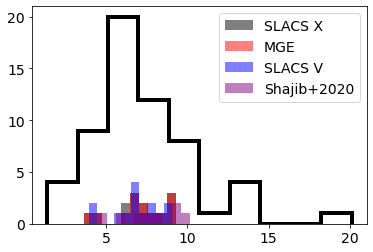

In [186]:
plt.hist(slacs_x.reff_kpc, color='k', histtype='step', linewidth=4) 
plt.hist(slacs_x_sample.reff_kpc, color='k', label='SLACS X', alpha=0.5)
plt.hist(reffs_kpc[not_na].value, color='r', label='MGE', alpha=0.5)
plt.hist(slacs_reffs_kpc, color='blue', label='SLACS V', alpha=0.5)
plt.hist(anowar_reffs_kpc, color='purple', label='Shajib+2020', alpha=0.5)
plt.legend()

# There is a HUGE difference in the effective radii inferred from these different works.
# Okay. I need to make a big inventory of where all of these are measured from...
### 1. MGE estimates from b-spline fits to ACS images, F435W or F814W ... Not corrected to restframe V band, measured as circular radius with area equal to the elliptical isophote containing half the light.
### 2. "slacs_reffs_kpc" from Bolton 2008 (SLACS V) are from ACS images, de Vaucouleur profile, restframe corrected to V band, measured at intermediate axis.
### 3. "slacs_x" from Bolton 2009 (SLACS X) are from ACS, WFPC2, etc, de Vaucouleur profile fit to multiple bands, restframe corrected to V band, measured at intermediate axis.
### 4. Anowar's stuff... Idk if it's been restframe corrected. Double-sersic profile.

In [187]:
slacs_reffs_kpc

0     7.858069
1     7.083879
2     5.938708
3     6.252253
4     4.137123
5     6.694055
6     6.760888
7     9.082554
8     6.894754
9     3.968882
10    8.243593
11    6.736174
12    7.618490
13    8.811959
Name: reff_slacs_v, dtype: float64

In [188]:
print(std_rat_slacs)

0.20757542493912112


In [194]:
classifications.columns

Index(['obj_name', 'class', 'subclass', 'comments', 'ellipticity',
       'V_sigma_mge', 'lambda_R_mge', 'PA_phot', 'delta_PA', 'PA_kin',
       'dPA_kin', 'oblate_prolate', 'SLACS delta_PA', 'V_aperture_mge',
       'VD_aperture_mge', 'dVD_aperture_mge', 'Vrms_aperture_mge', 'SLACS VD',
       'SLACS dVD', 'PA_kin_bspline', 'dPA_kin_bspline', 'PA_phot_bspline',
       'delta_PA_bspline', 'ellipticity_bspline', 'kcwi_sigmapsf_bspline',
       'reff_slacs_x', 'ellipticity_slacs', 'reff_mge', 'reff_maj_mge',
       'eps_reff_ellipse_mge', 'luminosities_mge', 'reff_slacs_v',
       'pa_slacs_v', 'VD_slacs_asb', 'dVD_slacs_asb', 'V_sigma_bin',
       'lambda_R_bin', 'D_ap_bin', 'dV_ap_bin', 'VD_ap_bin', 'dVD_ap_bin',
       'V_sigma_pix', 'lambda_R_pix', 'V_ap_pix', 'dV_ap_pix', 'VD_ap_pix',
       'dVD_ap_pix', 'V_aperture_mge', 'VD_aperture_mge', 'Vrms_aperture_mge',
       'V_sigma_class', 'lambda_R_class', 'stellar_mass', 'V_aperture',
       'VD_aperture', 'Vrms_aperture', 'anowar_ref

In [211]:
classifications['zlens'] = np.array(zlens)
classifications['zsource'] = np.array(zsource)

# save classifications table


In [213]:
# save classifications
#date='022223'
#classifications.to_csv(f'{data_dir}classification_table_{date}.csv',index=False)

In [214]:
# make a classifications table for Pritom

pritom = classifications[['obj_name',
                         'zlens',
                         'zsource',
                         'ellipticity',
                         'V_sigma_mge',
                         'lambda_R_mge']]

In [215]:
pritom

,obj_name,zlens,zsource,ellipticity,V_sigma_mge,lambda_R_mge
0,SDSSJ0029-0055,0.227,0.931,0.130,0.107911,0.084878
1,SDSSJ0037-0942,0.195,0.632,0.300,0.176446,0.158571
2,SDSSJ0330-0020,0.351,1.071,0.170,0.129017,0.109658
3,SDSSJ1112+0826,0.273,0.629,0.240,0.263330,0.234192
4,SDSSJ1204+0358,0.164,0.631,0.090,0.077882,0.068771
5,SDSSJ1250+0523,0.232,0.795,0.040,0.127693,0.112299
6,SDSSJ1306+0600,0.173,0.472,0.091,0.108517,0.091037
7,SDSSJ1402+6321,0.205,0.481,0.220,0.095982,0.082576
8,SDSSJ1531-0105,0.160,0.744,0.310,0.078509,0.069539
9,SDSSJ1538+5817,0.143,0.531,0.220,0.064735,0.049908


In [216]:
#pritom.to_csv(f'{data_dir}slacs_table_vsigma_lambdar.csv')

_________________________
# I moved this section below down because I don't need it right now.

_________________________________
# 02/06/23 - Make a mass estimate from the virial theorem:
# $ \frac{3}{5} \frac{G M}{R} = \frac{1}{2} V^2 = \frac{3}{2} \sigma^2$

or

# $ M_{dyn} = \frac{5 r_{eff} \sigma^2}{2 G}$

In [399]:
import astropy.constants as c
import astropy.units as u

In [400]:
G_unit = c.G.to(u.kpc * u.km**2 / u.M_sun / u.s**2)

In [401]:
G_unit

<Quantity 4.30091727e-06 km2 kpc / (s2 solMass)>

In [402]:
#slacs_reffs = classifications['SLACS_reff']
#reffs = classifications['effective_radius']
#reffs[6] = classifications.loc[6, 'SLACS reff']
#reff_majs = classifications['reff_maj']

In [403]:
#from astropy.cosmology import Planck15 as cosmo
reffs_kpc = cosmo.angular_diameter_distance(zs).to(u.kpc)*reffs/206265
reffs_slacs_kpc = cosmo.angular_diameter_distance(zs).to(u.kpc)*slacs_reffs/206265
reff_majs_kpc = cosmo.angular_diameter_distance(zs).to(u.kpc)*reff_majs/206265
reffs_kpc

<Quantity [ 8.01722808,  7.20634938,  6.70199577,  5.61485864,  3.0235612 ,
            4.56091683, -3.03408154,  6.57172917,  6.19834877,  3.86992234,
            7.03960974,  5.55186769,  4.8667864 ,  6.59771606] kpc>

In [404]:
# calculate the dynamical mass from integrated velocity dispersion
M_dyn = 5 * reffs_kpc * (classifications.VD_ap_pix)**2 / (2 * G_unit)* (u.km/u.s)**2
M_dyn


<Quantity [ 1.84333259e+11,  2.80494226e+11,  1.95002431e+11,
            2.18300613e+11,  1.13289265e+11,  1.41828185e+11,
           -8.94518430e+10,  2.81668644e+11,  2.36234051e+11,
            1.15632765e+11,  2.46333228e+11,  2.11202694e+11,
            1.96065530e+11,  2.30892058e+11] solMass>

In [405]:
classifications.stellar_mass

0     4.623810e+11
1     6.324119e+11
2     3.273407e+11
3     7.194490e+11
4     3.589219e+11
5     4.446313e+11
6     2.691535e+11
7     6.576578e+11
8     6.309573e+11
9     1.678804e+11
10    5.188000e+11
11    6.280584e+11
12    6.295062e+11
13    5.847901e+11
Name: stellar_mass, dtype: float64

In [406]:
# look in log space
log_Mdyn = np.log10(M_dyn.value)
not_na = np.isfinite(log_Mdyn)
log_Mstar = np.log10(classifications.stellar_mass)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [407]:
# linear fit in log space
m, b = np.polyfit(log_Mdyn[not_na], log_Mstar[not_na], deg=1)
print(m, b)

1.0388469219091663 -0.04205842997028012


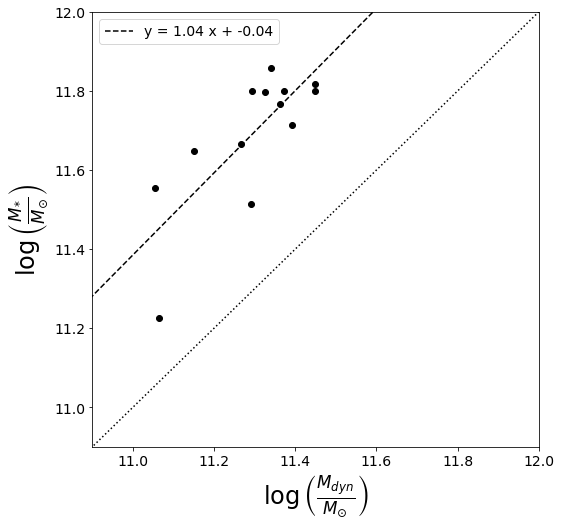

In [408]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(log_Mdyn[not_na], log_Mstar[not_na],
          c='k')
ax.set_ylim(10.9, 12)
ax.set_xlim(10.9, 12)
ax.set_xlabel(r'$\log\left(\frac{M_{dyn}}{M_{\odot}}\right)$', fontsize=24)
ax.set_ylabel(r'$\log\left(\frac{M_{*}}{M_{\odot}}\right)$', fontsize=24)
x = np.linspace(10.7, 12.1, 1000)
y = m * x + b
ax.plot(x, y, c='k', linestyle='--', label=f'y = {"{:.2f}".format(m)} x + {"{:.2f}".format(b)}')
y2 = x
ax.plot(x, y2, c='k', linestyle=':')
ax.legend()

# We also want to look at the mass-size relation and the mass plane (MP, M, sigma, reff_maj)

In [409]:
log_reff_maj = np.log10(reff_majs_kpc.value)
log_slacs_reff = np.log10(reffs_slacs_kpc.value)
log_reff_maj

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


array([0.94338851, 0.93380284, 0.89048236, 0.81144831, 0.49174609,
       0.67026203,        nan, 0.87804921, 0.87575891, 0.63263174,
       0.91016047, 0.77573926, 0.73578239, 0.90509906])

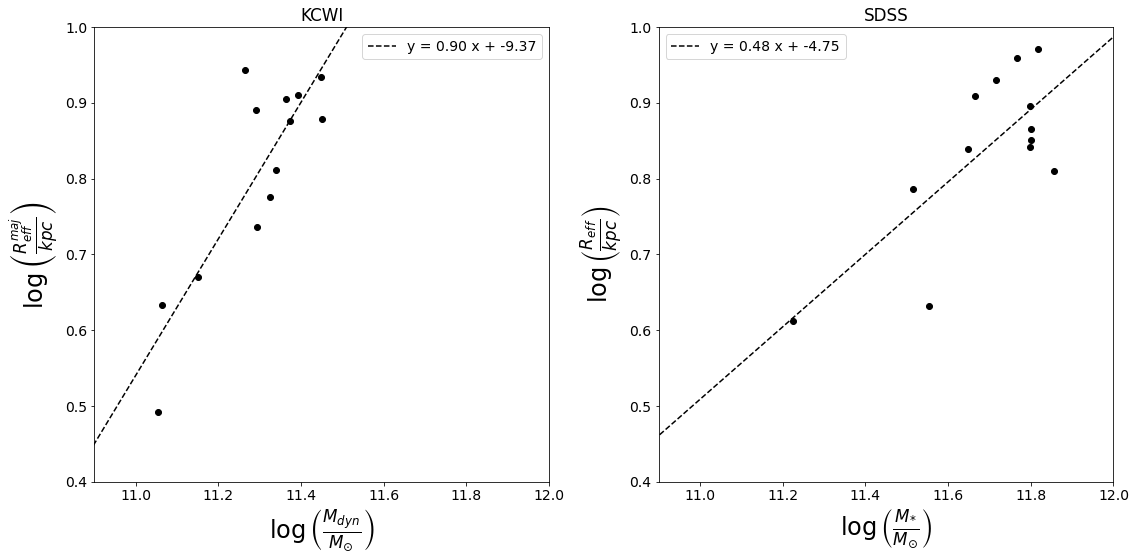

In [410]:
not_na = np.isfinite(log_reff_maj)

m0, b0 = np.polyfit(log_Mdyn[not_na], log_reff_maj[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_slacs_reff[not_na], 1)
x = np.linspace(10.7, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fig, ax = plt.subplots(1, 2, figsize=(16,8))

# dynamical mass to reff
ax[0].scatter(log_Mdyn[not_na], log_reff_maj[not_na], 
          c='k')
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')
ax[0].set_xlim(10.9, 12)
ax[0].set_ylim(0.4, 1.0)
ax[0].set_ylabel(r'$\log\left(\frac{R_{eff}^{maj}}{kpc}\right)$', fontsize=24)
ax[0].set_xlabel(r'$\log\left(\frac{M_{dyn}}{M_{\odot}}\right)$', fontsize=24)
ax[0].legend()
ax[0].set_title('KCWI')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_slacs_reff[not_na], 
          c='k')
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.9, 12)
ax[1].set_ylim(0.4, 1.0)
#ax[0].set_xlim(10.8, 11.7)
ax[1].set_ylabel(r'$\log\left(\frac{R_{eff}}{kpc}\right)$', fontsize=24)
ax[1].set_xlabel(r'$\log\left(\frac{M_{*}}{M_{\odot}}\right)$', fontsize=24)        
ax[1].legend()
ax[1].set_title('SDSS')
        
#ax[0].legend()
plt.tight_layout()

In [411]:
log_VD = np.log10(classifications.VD_ap_pix)
#log_VD_sdss = np.log10(classifications['SLACS_VD_B08'])
# This should be the updated one
log_VD_sdss = np.log10(classifications.VD_slacs_asb)

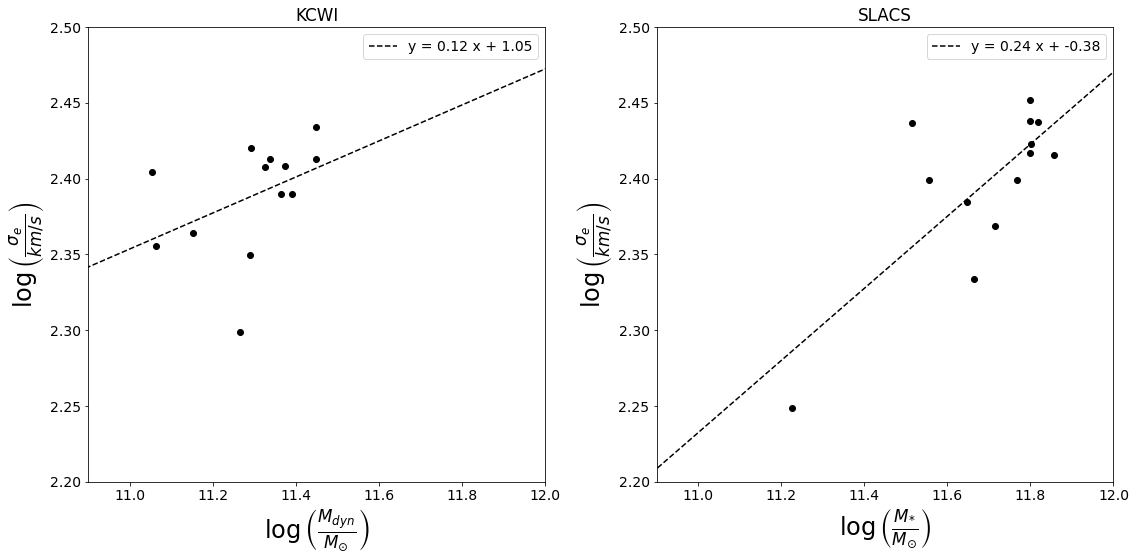

In [412]:
m0, b0 = np.polyfit(log_Mdyn[not_na], log_VD[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_VD_sdss[not_na], 1)
x = np.linspace(10.7, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fig, ax = plt.subplots(1, 2, figsize=(16,8))

# dynamical mass to reff
ax[0].scatter(log_Mdyn[not_na], log_VD[not_na], 
          c='k')
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')
ax[0].set_xlim(10.9, 12)
ax[0].set_ylim(2.2, 2.5)
ax[0].set_ylabel(r'$\log\left(\frac{\sigma_{e}}{km/s}\right)$', fontsize=24)
ax[0].set_xlabel(r'$\log\left(\frac{M_{dyn}}{M_{\odot}}\right)$', fontsize=24)
ax[0].legend()
ax[0].set_title('KCWI')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_VD_sdss[not_na], 
          c='k')
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.9, 12)
ax[1].set_ylim(2.2, 2.5)
#ax[0].set_xlim(10.8, 11.7)
ax[1].set_ylabel(r'$\log\left(\frac{\sigma_{e}}{km/s}\right)$', fontsize=24)
ax[1].set_xlabel(r'$\log\left(\frac{M_{*}}{M_{\odot}}\right)$', fontsize=24)        
ax[1].legend()
ax[1].set_title('SLACS')
        
#ax[0].legend()
plt.tight_layout()

# Let's look at the mass plane. From virial relation:

# $ \log(\sigma_e) = 1/2 \log(M) - 1/2[log(5 R_e / 2 G)] $

and

# $ \log(R_e) = \log(M) - log(5 \sigma_e^2 / 2 G) $

In [413]:
# calculate lines of constant Re and constant sigma e
# as in Cappellari 2016 review Figure 20

# same values shown in Cap2016 Fig 20
const_sigmas = np.array([#50, # km/s
                       #100,
                       200,
                       300,
                       400,
                       500
                        ]
                      )

const_res = np.array([0.1, # kpc
                    1,
                    10,
                    100]
                   )

# calculate the intercepts as above
const_sigmas_int = - np.log10( 5 * const_sigmas**2 / (2 * G_unit.value))
const_res_int = - 1/2 * np.log10( 5 * const_res / (2 * G_unit.value))

# take range of masses
masses = np.linspace(10.8, 12.0, 100)

# calculate the lines
lines_const_sigmas = np.zeros((len(const_sigmas),len(masses)))
lines_const_res = np.zeros((len(const_res),len(masses)))

for i, intercept in enumerate(const_sigmas_int):
    lines_const_sigmas[i] = masses + intercept
for i, intercept in enumerate(const_res_int):
    lines_const_res[i] = 1/2 * masses + intercept
 

In [414]:
const_sigmas_int

array([-10.36643891, -10.71862143, -10.9684989 , -11.16231893])

In [415]:
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()

In [416]:
log_ml_rs[6] = 'NaN'

In [417]:
log_ml_rs

array([0.693, 0.665, 0.487, 0.793, 0.835, 0.548,   nan, 0.706, 0.728,
       0.577, 0.571, 0.83 , 0.671, 0.779])

In [418]:
# take log ml for my models
log_lum = np.log10(classifications.luminosities)
log_ml_kcwi = log_Mdyn - log_lum
log_ml_kcwi

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


0     0.347553
1     1.479391
2     0.290703
3     0.291745
4     1.548111
5     1.292684
6          NaN
7     1.621943
8     0.340129
9     0.417650
10    1.483036
11    1.699182
12    1.561979
13    1.618704
Name: luminosities, dtype: float64

# Zone of exclusion from Cap 2013a

# $R_e^{maj} = R_{e,b} (M_{JAM}/M_{JAM,b})^{\gamma} [1/2 + 1/2 (M_{JAM}/M_{JAM,b})^{\alpha}]^{(\beta - \gamma)/(\alpha)}$
# $\log(R_e^{maj}) = \log(R_{e,b})  + \gamma \log(M/M_b) + (\beta - \gamma)/\alpha \log(1/2 + 1/2 (M/M_b)^{\alpha}) $
## $R_{e,b} = 0.7$ kpc
## $\alpha = 8$
## $\beta = 0.75 $
## $ \gamma = -0.20$
## $M_b = 3.0 \times 10^{10} M_{\odot} $

In [419]:
reb = 0.7
alpha = 8
beta = 0.75
gamma = -0.20
Mb = 3e10

masses_zoe = np.linspace(10, 12, 100)

zoe = np.log10(reb) + gamma * np.log(10**masses_zoe/Mb) + (beta - gamma)/alpha * np.log10(1/2 + 1/2 * (10**masses_zoe/Mb)**alpha)

mean_beta = 0.57
mean_gamma = 0.12

mean_zoe = np.log10(reb) + mean_gamma * np.log(10**masses_zoe/Mb) + (mean_beta - mean_gamma)/alpha * np.log10(1/2 + 1/2 * (10**masses_zoe/Mb)**alpha)


In [420]:
# From Cap2016 review Mcrit 2e11 separates fast and slow
M_crit = np.log10(2e11)

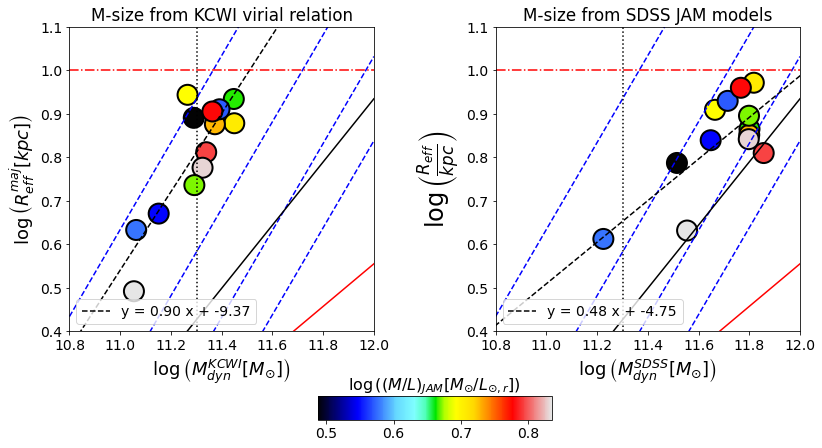

In [421]:
m0, b0 = np.polyfit(log_Mdyn[not_na], log_reff_maj[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_slacs_reff[not_na], 1)
x = np.linspace(10.7, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fontsize = 18

fig, ax = plt.subplots(1, 2, figsize=(14,8))#, sharey=True)
#plt.subplots_adjust(wspace=-0.2)

# dynamical mass to reff
p = ax[0].scatter(log_Mdyn[not_na], log_reff_maj[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
cb = fig.colorbar(p, location='bottom', orientation='horizontal', ax=ax[:], shrink = 0.3, aspect=10)
cb.ax.set_title(r'$\log\left({(M/L)_{JAM}}[M_{\odot}/L_{\odot,r}]\right)$', fontsize=fontsize-2)
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')  
# plot lines of constant sigma and reff
for line in lines_const_sigmas:
    ax[0].plot(masses, line, 'b--')
    ax[1].plot(masses, line, 'b--')
for re in const_res:
   ax[0].axhline(np.log10(re), 0, 1, c='r', linestyle='-.')
   ax[1].axhline(np.log10(re), 0, 1, c='r', linestyle='-.')
# plot zoe
ax[0].plot(masses_zoe, zoe, 'r')
ax[1].plot(masses_zoe, zoe, 'r')
# plot mean zoe
ax[0].plot(masses_zoe, mean_zoe, 'k')
ax[1].plot(masses_zoe, mean_zoe, 'k')
# plot mcrit
ax[0].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[1].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[0].set_xlim(10.8, 12)
ax[0].set_ylim(0.4, 1.1)
ax[0].set_ylabel(r'$\log\left(R_{eff}^{maj} [kpc]\right)$', fontsize=fontsize)
ax[0].set_xlabel(r'$\log\left(M_{dyn}^{KCWI} [{M_{\odot}}]\right)$', fontsize=fontsize)
ax[0].set_box_aspect(1)
ax[0].legend(loc='lower left')
ax[0].set_title(r'M-size from KCWI virial relation')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_slacs_reff[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.8, 12)
ax[1].set_ylim(0.4, 1.1)
#ax[0].set_xlim(10.8, 11.7)
ax[1].set_ylabel(r'$\log\left(\frac{R_{eff}}{kpc}\right)$', fontsize=24)
ax[1].set_xlabel(r'$\log\left(M_{dyn}^{SDSS}[M_{\odot}]\right)$', fontsize=fontsize)  
ax[1].set_box_aspect(1)
ax[1].legend(loc='lower left')
ax[1].set_title('M-size from SDSS JAM models')
        
#ax[0].legend()
#plt.tight_layout()
plt.savefig(f'{figure_dir}mass_size_{date}.pdf', bbox_inches='tight')
plt.savefig(f'{figure_dir}mass_size_{date}.png', bbox_inches='tight')

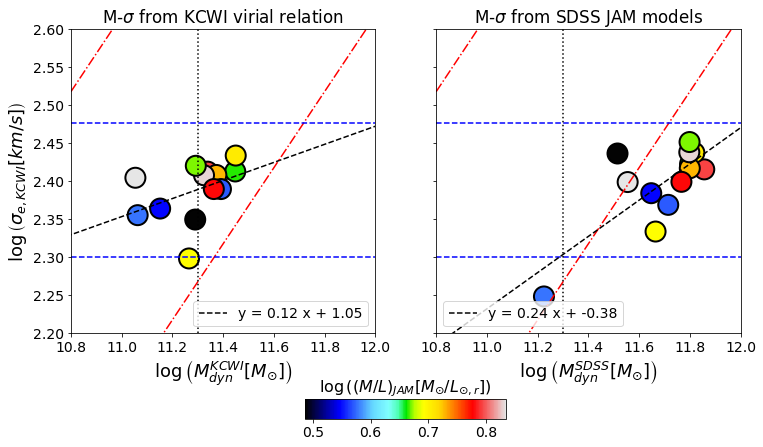

In [422]:
m0, b0 = np.polyfit(log_Mdyn[not_na], log_VD[not_na], 1)
m1, b1 = np.polyfit(log_Mstar[not_na], log_VD_sdss[not_na], 1)
x = np.linspace(10.5, 12.1, 1000)
y0 = m0 * x + b0
y1 = m1 * x + b1

fontsize = 18

fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True)
#plt.subplots_adjust(wspace=-0.2)

# dynamical mass to sigma
p = ax[0].scatter(log_Mdyn[not_na], log_VD[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
cb = fig.colorbar(p, location='bottom', orientation='horizontal', ax=ax[:], shrink = 0.3, aspect=10)
cb.ax.set_title(r'$\log\left({(M/L)_{JAM}}[M_{\odot}/L_{\odot,r}]\right)$', fontsize=fontsize-2)
ax[0].plot(x, y0, 'k--', label=f'y = {"{:.2f}".format(m0)} x + {"{:.2f}".format(b0)}')
for line in lines_const_res:
    ax[0].plot(masses, line, 'r-.')
    ax[1].plot(masses, line, 'r-.')
for sigma in const_sigmas:
   ax[0].axhline(np.log10(sigma), 0, 1, c='b', linestyle='--')
   ax[1].axhline(np.log10(sigma), 0, 1, c='b', linestyle='--')
# plot mcrit
ax[0].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[1].axvline(M_crit, 0, 1, c='k', linestyle=':')
ax[0].set_xlim(10.8, 12)
ax[0].set_ylim(2.2, 2.6)
ax[0].set_ylabel(r'$\log\left(\sigma_{e,KCWI}[km/s]\right)$', fontsize=fontsize)
ax[0].set_xlabel(r'$\log\left(M_{dyn}^{KCWI} [{M_{\odot}}]\right)$', fontsize=fontsize)
ax[0].set_box_aspect(1)
ax[0].legend()
ax[0].set_title(r'M-$\sigma$ from KCWI virial relation')

# stellar mass to reff
ax[1].scatter(log_Mstar[not_na], log_VD_sdss[not_na], 
          c=log_ml_rs[not_na], cmap='sauron', s=400, edgecolor='k', linewidth=2)
ax[1].plot(x, y1, 'k--', label=f'y = {"{:.2f}".format(m1)} x + {"{:.2f}".format(b1)}')
ax[1].set_xlim(10.8, 12)
ax[1].set_ylim(2.2, 2.6)
#ax[0].set_xlim(10.8, 11.7)
#ax[1].set_ylabel(r'$\log\left(\frac{\sigma_{e}}{km/s}\right)$', fontsize=fontsize)
ax[1].set_xlabel(r'$\log\left(M_{dyn}^{SDSS}[M_{\odot}]\right)$', fontsize=fontsize)      
ax[1].set_box_aspect(1)
ax[1].legend(loc='lower left')
ax[1].set_title(r'M-$\sigma$ from SDSS JAM models')
        
#ax[0].legend()
#plt.tight_layout()
plt.savefig(f'{figure_dir}mass_sigma_{date}.pdf', bbox_inches='tight')
plt.savefig(f'{figure_dir}mass_sigma_{date}.png', bbox_inches='tight')

In [ ]:
hst_scale = 0.1457

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f4e716cc940>]>
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1922                                                  NAXIS2  =                 1935                                                  EXTEND  =                    T                                                  CRPIX1  =                961.0                                                  CRPIX2  =                967.5                                                  CRVAL1  =    196.5567845112902                                                  CRVAL2  =    6.005651022120135                                                  CD1_1   = -1.3888888888888E-05                                                  CD1_2   =              

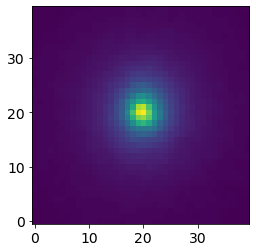

In [264]:
hdul = fits.open('/data/raw_data/HST_SLACS_ACS/J1306+0600_WFPC2_F606W/J1306+0600_F606W_u9op52_3_sci.fits')
hdul.verify('fix')
print(hdul.info)
data1 = hdul[0].data
header1 = hdul[0].header
print(header1)
central_pix = np.unravel_index(np.argmax(data1, axis=None), data1.shape)
xc = central_pix[1]
yc = central_pix[0] 
crop_data1 = data1[yc-20:yc+20,xc-20:xc+20]
plt.imshow(crop_data1, origin='lower')
hdul.close()

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f4e71a73208>]>
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 2087                                                  NAXIS2  =                 2062                                                  EXTEND  =                    T                                                  CRPIX1  =               1043.5                                                  CRPIX2  =               1031.0                                                  CRVAL1  =    196.5564917922205                                                  CRVAL2  =    6.005828661684845                                                  CD1_1   = -1.3888888888888E-05                                                  CD1_2   =              

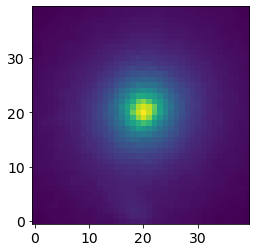

In [262]:
#'data/raw_data/HST_SLACS_ACS/J1306+0600_WFPC2_F606W/J1306+0600_F606W_ua1l36_3_sci.fits
hdul = fits.open('/data/raw_data/HST_SLACS_ACS/J1306+0600_WFPC2_F606W/J1306+0600_F606W_ua1l36_3_sci.fits')
hdul.verify('fix')
print(hdul.info)
data2 = hdul[0].data
header2 = hdul[0].header
print(header2)
central_pix = np.unravel_index(np.argmax(data2, axis=None), data2.shape)
xc = central_pix[1]
yc = central_pix[0] 
crop_data2 = data2[yc-20:yc+20,xc-20:xc+20]
plt.imshow(crop_data2, origin='lower')
hdul.close()

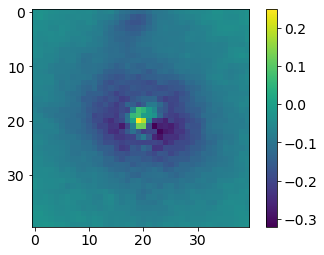

In [267]:
a = plt.imshow(crop_data1-crop_data2)
plt.colorbar(a)

In [119]:
Sigma_tots_kcwi

array([ 3.28726982e+08,  6.33167020e+08,  4.84329833e+08,  8.10578521e+08,
        1.39449066e+09,  7.85479117e+08, -1.11057380e+09,  7.55562160e+08,
        7.33940934e+08,  8.81184556e+08,  5.96425505e+08,  7.56321601e+08,
        9.56444708e+08,  5.68766951e+08])

In [ ]:
fig, axs = plt.subplots(figsize=(8,8))

axs.errorbar(np.log10(reffs_kpc[nnnl].value), gammas[nnnl], 
            xerr=dreffs[nnnl], 
             yerr=dgammas[nnnl], 
             color='k',
            linestyle='')
#axs.scatter(slacs_reffs[nnnl], gammas[nnnl], 
#            #xerr=dslacs_reffs[nnnl], yerr=dgammas[nnnl], 
#             color='r',
#            linestyle='')


# fit a line
p, cov = np.polyfit(np.log10(reffs_kpc[nnnl].value), gammas[nnnl], 
                    deg=1,
                    w=1/(dgammas[nnnl]**2),
                    cov=True)
m = p[0]
b = p[1]
err = np.sqrt(np.diag(cov))/np.sqrt(len(gammas[nnnl]))
merr = err[0]
berr = err[1]
x = np.linspace(0.4, 1.0, 100)
y = m*x+b
ylo = (m-merr)*x+(b-berr)
yhi = (m+merr)*x+(b+berr)
ylo = (m-merr)*x+(b-berr)
yhi = (m+merr)*x+(b+berr)
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
axs.plot(x, y, 'r-',
                label=label)
axs.fill_between(x, ylo, yhi, 
                 color='r',
                alpha=0.1)

# slacs x lines
# a = 0.18±0.03, b = 2.34±0.01
m = -0.41
merr = 0.12
b = 0.39+2
berr = 0.10
x = np.linspace(0.4, 1.0, 100)
y = m*x+b
ylo = (m-merr)*x+(b-berr)
yhi = (m+merr)*x+(b+berr)
label = f'a={"{:.2f}".format(m)}$\pm${"{:.2f}".format(merr)}, b={"{:.2f}".format(b)}$\pm${"{:.2f}".format(berr)}'
axs.plot(x, y, 'k--',
        label=label)
axs.fill_between(x, ylo, yhi, 
                 color='k',
                alpha=0.05)

axs.set_xlim(0.4, 1.0)
axs.set_xlabel(r'$\log{r_{eff}}$ [kpc]')#'\log\left(M_*/10^{11}M_{\odot}\right)$')
axs.set_ylabel(r'$\gamma$')
axs.legend()